In [3]:
%pylab inline
import pandas as pd
import cPickle

Populating the interactive namespace from numpy and matplotlib


In [4]:
# Import the numerical results
resultsGamma = cPickle.load(open("resultsTOT_ALL_NEW_-home-ubi-urns-data_analyzed-.pkl", "rb"))
resultsBeta  = cPickle.load(open("resultsTOT_ALL_NEW_clustTriangsNusBetas_-home-ubi-urns-out-.pkl", "rb"))

In [5]:
# Import the numerical results
resultsGamma = cPickle.load(open("resultsTOT_ALL_DEFINITIVE_-home-ubi-urns-data_analyzed-.pkl", "rb"))
resultsBeta  = cPickle.load(open("resultsTOT_ALL_DEFINITIVE_clustTriangsNusBetas_-home-ubi-urns-out-.pkl", "rb"))

In [6]:
# Or import the newly created single file done with mpi
resultsUnique = cPickle.load(open("resultsTOT_ALL_MPI_clustTriangsNusBetas_-home-ubi-urns-out-.pkl", "rb"))

In [7]:
# Or import the newly created single file done with mpi
resultsUnique = cPickle.load(open("resultsTOT_ALL_MPI_RATge1-home-ubi-urns_serie-out-.pkl", "rb"))

In [8]:
# Or import the newly created single file done with mpi
resultsUnique = cPickle.load(open("resultsTOT_ALL_MPI_FINAL_-home-ubi-urns_serie-out-.pkl", "rb"))

In [9]:
selCols =  ["A_e", "A_c", "D_c", "D_e", "F_c", "F_e", "p_to_f",
            "run_idx", "Ev_Steps", "k_a_t", "beta_opt", "Fa_nu", "Fk_mu",
            "new-close", "old-close", "new-open", "old-open", "clust_t",
            
           ]
df = pd.DataFrame.from_dict({(son, exc, rat, rho, i):
        {k: rhoD[k][i] if k!="k_a_t" else rhoD[k][i][2] for k in selCols}
                  for son, sonD in resultsUnique.iteritems()
                   for exc, excD in sonD.iteritems()
                    for rat, ratD in excD.iteritems()
                     for rho, rhoD in ratD.iteritems()
                      for i in range(len(rhoD["Ev_Steps"]))
                if rhoD["Ev_Steps"][i] >= 1000}, orient="index")#, columns=selCols)

df.index.names = ["son", "exc", "rat", "rho", "id"]
df.head()

F_e     Fk_mu     Fa_nu        F_c  new-close  \
son exc rat rho id                                                       
0   0   0.2 1.0 0   0.989698  2.384151  2.269518  1993000.0   0.158947   
                1   0.986886  2.387809  2.283242  1974000.0   0.156659   
                2   0.991365  2.385469  2.279731  1988000.0   0.158958   
                3   0.991377  2.390890  2.281827  1981000.0   0.157530   
                4   0.988869  2.388301  2.272219  1978000.0   0.157604   

                    old-close  new-open   clust_t       A_e       A_c  \
son exc rat rho id                                                      
0   0   0.2 1.0 0    0.080281  0.632184  0.081948  0.998675  791400.0   
                1    0.080672  0.633532  0.083226  0.998035  791100.0   
                2    0.080692  0.632988  0.082504  1.000000  791600.0   
                3    0.080525  0.633870  0.082718  0.999953  791500.0   
                4    0.080302  0.632944  0.081992  0.998075  791200.0   

                    Ev_Steps    p_to_f  old-open       D_c     k_a_t  run_idx  \
son exc rat rho id                                                              
0   0   0.2 1.0 0     500000  0.394417  0.128588  257800.0  0.574133        8   
                1     500000  0.407688  0.129136  259500.0  0.564023        9   
                2     500000  0.401565  0.127362  258200.0  0.576659        0   
                3     500000  0.409078  0.128075  259200.0  0.570359        1   
                4     500000  0.399915  0.129150  259600.0  0.555787        2   

                    beta_opt       D_e  
son exc rat rho id                      
0   0   0.2 1.0 0       0.13  0.989698  
                1       0.12  0.986886  
                2       0.13  0.991365  
                3       0.13  0.991377  
                4       0.13  0.988869

In [10]:
def scoreRow(row, dataset, weights):
    #print row
    rowscore = 0
    for what, weight in weights.iteritems():
        ref_val = row[what]
        rowscore += np.abs(dataset[what] - ref_val)*weight
    return rowscore

def scoreGroup(group, dataset, weights, columnName, median=True,
               weighted=False, weightKey="Ev_Steps"):
    #print row
    assert not(median and weighted)
    groupscore = 0
        
    for what, weight in weights.iteritems():
        if median:
            ref_val = np.median(group[what])
        else:
            if weighted:
                pesi = np.array(group[weightKey])
            else:
                pesi = np.ones(group.shape[0])
            ref_val = np.average(group[what], weights=pesi)
        groupscore += np.abs(dataset[what] - ref_val)*weight
    group[columnName] = groupscore
    return group

def computeAllTheScores(df, dataset, weights):
    dfTWT = df.copy(deep=True)
    dfTWT["singleScore"] = dfTWT.apply(scoreRow, axis=1, args=(dataset, weights))
    
    dfTWTGroup = dfTWT.groupby(["son", "exc", "rat", "rho"])
    dfTWTGroup = dfTWTGroup.apply(scoreGroup, dataset, weights,
                                  median=True, columnName="medianObsScore")

    dfTWTGroup = dfTWTGroup.groupby(["son", "exc", "rat", "rho"])
    dfTWTGroup = dfTWTGroup.apply(scoreGroup, dataset, weights,
                                  median=False, weighted=False, columnName="averageObsScore")

    dfTWTGroup = dfTWTGroup.groupby(["son", "exc", "rat", "rho"])
    dfTWTGroup = dfTWTGroup.apply(scoreGroup, dataset, weights,
                                  median=False, weighted=True, columnName="weightAvgObsScore")

    dfTWTGroup["medianScore"] = dfTWTGroup.groupby(["son", "exc", "rat", "rho"],
                                                   as_index=False)["singleScore"].transform(np.median)
    dfTWTGroup["averageScore"] = dfTWTGroup.groupby(["son", "exc", "rat", "rho"],
                                                   as_index=False)["singleScore"].transform(np.average)

    def medianScoreGroup(g):
        g["weightAvgScore"] = np.average(g["singleScore"], weights=g["Ev_Steps"])
        return g

    dfTWTGroup = dfTWTGroup.groupby(["son", "exc", "rat", "rho"]).apply(medianScoreGroup)
    
    return dfTWTGroup

In [11]:
import pandas as pd
from math import pi
from copy import deepcopy

def radarPlotDF(dataset, dfRow, dataName, yticks=[.25, .5, .75, 1.], groupCol="group",
              categoriesDict=None, cat_label_size=18, yticks_size=12, rescaleDict=None, additionalLabel=""):
    
    dataset_copy = deepcopy(dataset)
    res_copy = deepcopy(dfRow)
    if rescaleDict:
        for k, scale in rescaleDict.iteritems():
            dataset_copy[k] /= scale
            res_copy[k] /= scale
    
    rho_val, ratio_val = res_copy.index.unique("rho")[0],\
                                 res_copy.index.unique("rat")[0]
    nu_val = rho_val/ratio_val
    res_copy = {k: res_copy[k] for k in dataset_copy.keys()}
    df = pd.DataFrame([dataset_copy, res_copy],
                  index=[dataName, r"$\rho = %d,\; \nu = %d$" %
                         (rho_val, nu_val)]
                 )
    df["group"] = df.index
    df.reset_index(drop=True, inplace=True)

    # ------- PART 1: Create background

    # number of variable
    categories = []
    for c in df:
        if categoriesDict and c in categoriesDict:
            categories.append(categoriesDict[c])
        elif c != groupCol:
            categories.append(c)
    N = len(categories)

    # What will be the angle of each axis in the plot? (we divide the plot / number of variable)
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]

    # Initialise the spider plot
    ax = plt.subplot(111, polar=True)

    # If you want the first axis to be on top:
    ax.set_theta_offset(pi / 2)
    ax.set_theta_direction(-1)

    # Draw one axe per variable + add labels labels yet
    plt.xticks(angles[:-1], categories, size=cat_label_size)

    # Draw ylabels
    ax.set_rlabel_position(0)
    plt.yticks(yticks, ["%.02f" % v for v in yticks], color="black", alpha=.8, size=yticks_size)
    plt.ylim(0, max(yticks)*1.1)

    # ------- PART 2: Add plots

    # Plot each individual = each line of the data
    # I don't do a loop, because plotting more than 3 groups makes the chart unreadable

    # Ind1
    for iii in range (1, -1, -1):
        color = 'C%d' % (iii*3)
        name = df.loc[iii, groupCol]
        values = df.loc[iii].drop(groupCol).values.flatten().tolist()
        values += values[:1]
        ax.plot(angles, values, color=color, linewidth=.5 if iii > 0 else 2,
                linestyle='solid', marker="" if iii>0 else "o", label=name+(iii == 1)*additionalLabel)
        if iii > 0:
            ax.fill(angles, values, color=color, alpha=0.25)

    # Add legend
    leg = plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1),
                     fontsize=16, handlelength=.75)
    for line in leg.get_lines():
        line.set_linewidth(8.0)
    for lh in leg.legendHandles: 
        lh.set_alpha(.75)
    
def compareRadar(dataset, res_tot, son, sch, ratio, rho):
    # Building a fake result where I subsitiute the selected rho...
    # return (totRes, bestConf, bestScore, bestPars)
    tmp_res = (res_tot[0],
               res_tot[0][son][sch][ratio][rho]["conf"],
               res_tot[0][son][sch][ratio][rho]["score"],
               {"sonExch":son, "schExch": sch,
                "ratio": ratio, "rho": rho
               },
              )
               
    radarPlot(dataset=dataset, res=tmp_res, dataName="DATA")

In [12]:
def scoreHmapPlotDF(res, bestRow, fig=None, plotScale="lin", selectedScore="medianScore",
                    colorbar=None, vmin=.1, vmax=5, cmap="Blues_r", **kwargs):
    # Save the values...
    sonValues = res.index.unique("son")
    excValues = res.index.unique("exc")
    ratValues = res.index.unique("rat")
    rhoValues = res.index.unique("rho")
    
    nRows = len(sonValues)
    nCols = len(excValues)
    
    bestSon, bestSch = bestRow.index.unique("son")[0],\
                        bestRow.index.unique("exc")[0]
    bestRatio, bestRho = bestRow.index.unique("rat")[0],\
                          bestRow.index.unique("rho")[0]
    
    figsize=(6*nCols, 6*nRows)
    if fig is None:
        fig = plt.figure(figsize=figsize)
    else:
        fig.set_size_inches(figsize)
    gs1 = matplotlib.gridspec.GridSpec(nRows, nCols)
    #gs1.update(wspace=0.0275, hspace=0.0275)
    gs1.update(wspace=0.0275, hspace=0.095)
    
    noValue = 1e8
    
    subplot2title = ["WS", "WSW", "FSW",
                     "FS", "ASW", "SSW",  
                    ]
    
    for gTup, gVals in res.groupby(["son", "exc"]):
        sonExch, sampleStrat = gTup
        
        ratios = np.array(sorted(gVals.index.unique("rat")))
        possible_rhos = set(gVals.index.unique("rho"))
        minRho, maxRho = min(possible_rhos), max(possible_rhos)

        ratio2j = {r: i for i, r in enumerate(ratios)}
        rho2i   = {r: i for i, r in enumerate(sorted(possible_rhos))}

        n_HM_rows, n_HM_cols = len(rho2i), len(ratio2j)

        tmp_heatMap = np.ones((n_HM_rows, n_HM_cols))*noValue

        for tmp_tup, tmp_vals in gVals.groupby(["son", "exc", "rat", "rho"]):
            tmp_rat, tmp_rho = tmp_tup[2], tmp_tup[3]
            tmp_heatMap[rho2i[tmp_rho], ratio2j[tmp_rat]] = tmp_vals[selectedScore].min()

        subplot_index = sonExch*nCols + sampleStrat
        #ax = fig.add_subplot(nRows, nCols, subplot_index)
        ax = fig.add_subplot(gs1[subplot_index])
        ax.set_title(subplot2title[subplot_index], size=22)
        
        indexesToFix = np.where(tmp_heatMap == noValue)
        if plotScale == 'log':
            tmp_heatMap = np.log(tmp_heatMap)
        tmp_heatMap[indexesToFix] = vmax

        norm = matplotlib.colors.Normalize(vmin=vmin, vmax=vmax)
        img = ax.pcolormesh(tmp_heatMap, cmap=cmap, norm=norm, **kwargs)

        xticks, xlabs = [], []
        if sonExch == 1:
            ax.set_xlabel(r"$R$", size=30)
            xticks = [ratio2j[r]+.5 for r in sorted(ratios)[::2]]
            xlabs = [r"$%.02f$" % r for r in sorted(ratios)[::2]]

        yticks, ylabs = [], []
        if sampleStrat == 0:
            ax.set_ylabel(r"$\rho$", size=30)
            yticks = [rho2i[r]+.5 for r in sorted(possible_rhos)[::2]]
            ylabs = [r"$%d$" % r for r in sorted(possible_rhos)[::2]]

        ax.xaxis.set_tick_params(size=15)
        ax.xaxis.set_ticks(xticks)
        ax.xaxis.set_ticklabels(xlabs, size=22, rotation=90)

        ax.yaxis.set_tick_params(size=15)
        ax.yaxis.set_ticks(yticks)
        ax.yaxis.set_ticklabels(ylabs, size=22)

        if sonExch == bestSon and sampleStrat == bestSch:
                # Plot best solution
                ax.plot(ratio2j[bestRatio]+.5, rho2i[bestRho]+.5, "oC0",
                        ms=40, mew=5, markerfacecolor='none')

    cax = plt.axes([.925, .15, .025, .7])
    cb = fig.colorbar(img, cax=cax)
    cb.set_label(r"$\ln{S}$", size=30)
    cb.ax.tick_params(labelsize=22)
    
    fig.tight_layout()
    #plt.savefig("fig_Fa_Fk_exponents_%s.pdf" % file_prefix, bbox_inches='tight')
    return fig

In [13]:
def Nu(rho, ratio):
    return int(rho/float(ratio))

# TWT

Assortativity:
- REAL
        tot    (0.006189105991748784, 7.709363440136998e-05)
        scalar (-0.030678270688440392, 0.0001520922987662285) 
- URNS
       tot     (-0.019403736062386708, 0.00018340095065494852)
       scalar  (-0.002392660196871362, 0.0005406031689852493)



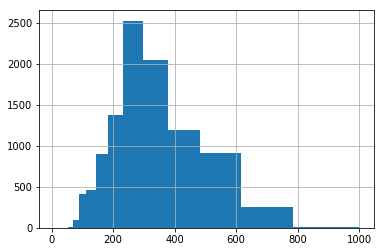

In [13]:
#TWT
datasetTWT = {
    "beta_opt": 0.46, "D_e": .87, "clust_t": .129, "k_a_t": .56928,
    "old-open": .237, "old-close": .616, "new-open": .072, "new-close": .074
          }

if False:
    weightsTWT = {
        "beta_opt": 1./.01, "D_e": 1./.003, "clust_t": 1./.0026,
        "k_a_t": 1./.048, "old-open": 1./.011, "old-close": 1./.017,
        "new-open": 1./.0052, "new-close": 1./.0017,
    }
else:
    weightsTWT = {
        "beta_opt": 1./.007591, "D_e": 1./.003, "clust_t": 1./.0026,
        "k_a_t": 1./.048, "old-open": 1./.009, "old-close": 1./.017,
        "new-open": 1./.0058, "new-close": 1./.0019,
    }
    
dfTWT = computeAllTheScores(df, dataset=datasetTWT, weights=weightsTWT)
dfTWT.singleScore.hist(bins=np.logspace(1,3,20))

                         F_e     Fk_mu     Fa_nu        F_c  new-close  \
son exc rat rho id                                                       
0   1   1.0 5.0 3   0.946938  2.332934  2.059624  1330000.0   0.085731   

                    old-close  new-open   clust_t       A_e       A_c  \
son exc rat rho id                                                      
0   1   1.0 5.0 3    0.537212  0.160667  0.132641  0.966736  500700.0   

                         ...        run_idx  beta_opt       D_e  singleScore  \
son exc rat rho id       ...                                                   
0   1   1.0 5.0 3        ...              7      0.54  0.946938    67.188223   

                    medianObsScore  averageObsScore  weightAvgObsScore  \
son exc rat rho id                                                       
0   1   1.0 5.0 3        70.046098        70.451451          70.451451   

                    medianScore  averageScore  weightAvgScore  
son exc rat rho id           

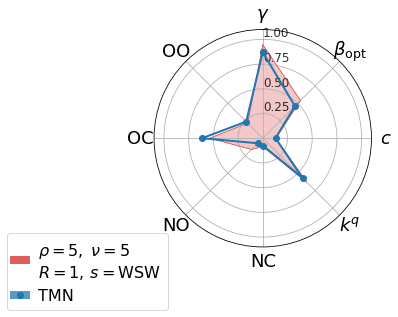

In [14]:
scoreToUse = "singleScore"
indexSlice = 0

if False:
    # Select by hand
    r = dfTWT[dfTWT[scoreToUse] == dfTWT[scoreToUse].min()].iloc[indexSlice:indexSlice+1]#["Ev_Steps"]
else:
    # Pick the closest in the group
    gr = dfTWT[dfTWT[scoreToUse] == dfTWT[scoreToUse].min()].iloc[indexSlice:indexSlice+1]#["Ev_Steps"]
    r = gr[gr["singleScore"] == gr["singleScore"].min()]
print r
radarPlotDF(datasetTWT, r, dataName="TMN",
          categoriesDict={
              "beta_opt": r"$\beta_{\rm opt}$", "D_e": r"$\gamma$",
              "clust_t": r"$c$", "k_a_t": r"$k^q$",
              "new-close": "NC", "new-open": "NO",
              "old-close": "OC", "old-open": "OO",
          }, additionalLabel="\n$R=1,\\,s=$WSW")
plt.savefig("radar_TWT.pdf", bbox_inches="tight")

In [15]:
r["k_a_t"]

son  exc  rat  rho  id
0    1    1.0  5.0  3     0.62766
Name: k_a_t, dtype: float64

/usr/lib/python2.7/site-packages/matplotlib/figure.py:2299: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


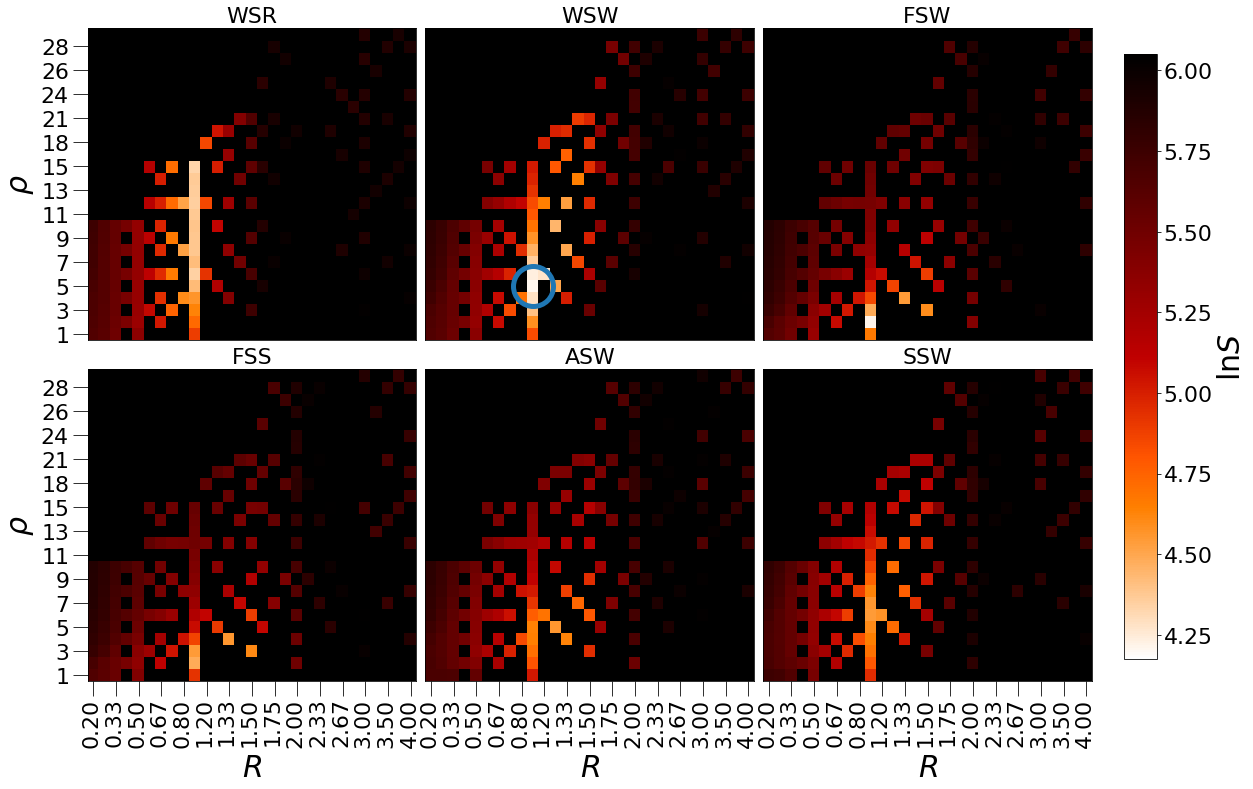

In [16]:
f = scoreHmapPlotDF(dfTWT, bestRow=r, selectedScore=scoreToUse, vmin=4.175, vmax=6.05,
                  plotScale="log", cmap="gist_heat_r",
                  lw=.0, edgecolors="#ffffff")
plt.savefig("score_TWT.pdf", bbox_inches="tight")

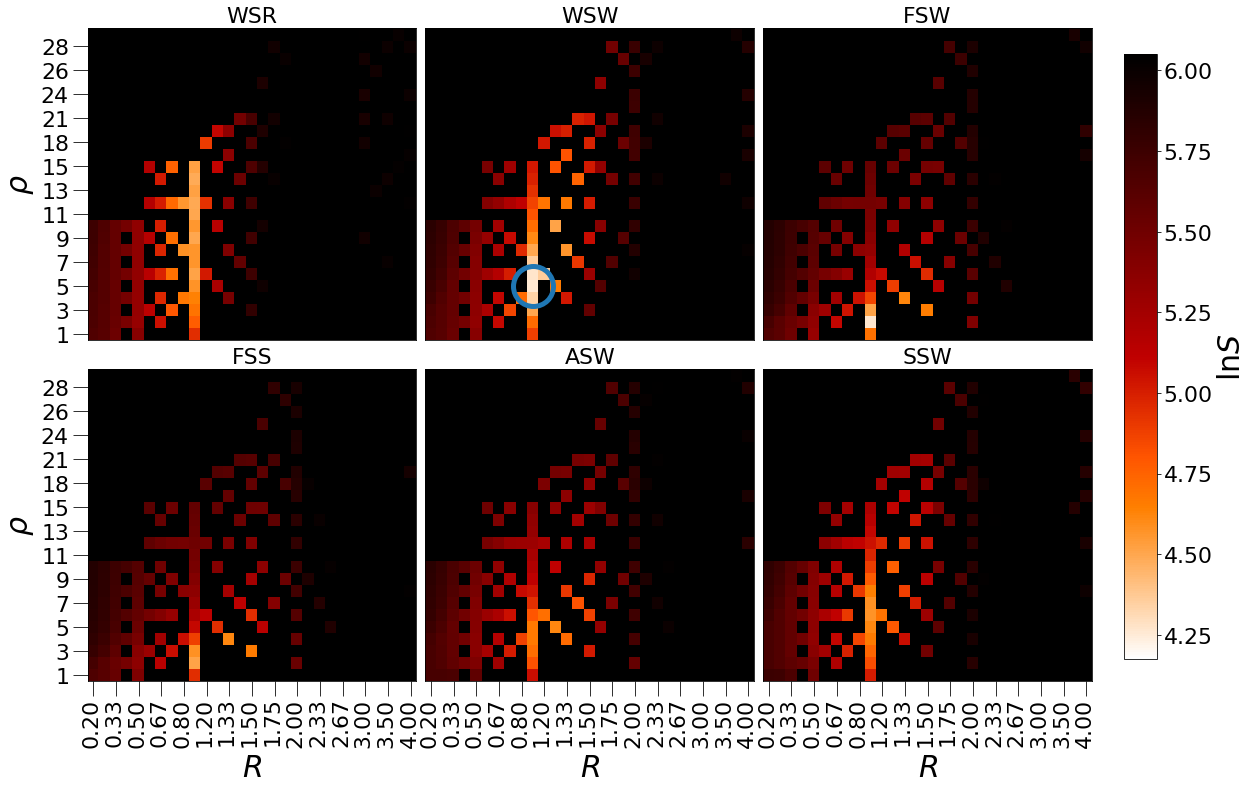

In [19]:
f = scoreHmapPlotDF(dfTWT, bestRow=r, selectedScore="medianScore", vmin=4.175, vmax=6.05,
                  plotScale="log", cmap="gist_heat_r",
                  lw=.0, edgecolors="#ffffff")
#plt.savefig("score_TWT.pdf", bbox_inches="tight")

# MPC

Assortativity:
- REAL:
        total  (-0.013981101097312761, 1.1299057125072008e-05)
        scalar (-0.0013191175106167562, 3.199388309944615e-05)       
- URNS:
        total  (-0.0462258366424652, 0.004528007793466812)
        scalar (0.02339030341709863, 0.018317333714864204)
 

In [20]:
selected_ratios = set(r for r in resultsGamma[0][0].keys() if r <= 4.)

In [21]:
#MPC
datasetMPC = {
    "beta_opt": 1.97, "D_e": .44, "clust_t": .115, "k_a_t": .335,
    "old-open": .50, "old-close": .476, "new-open": .00217, "new-close": .01
          }
if False:
    weightsMPC = {
    "beta_opt": 1./.01, "D_e": 1./.00067, "clust_t": 1./.0027, "k_a_t": 1./.0465,
    "old-open": 1./.00251, "old-close": 1./.0091, "new-open": 1./.0046, "new-close": 1./.0025,
          }
else:
    weightsMPC = {
    "beta_opt": 1./.01, "D_e": 1./.00067, "clust_t": 1./.001, "k_a_t": 1./.0465,
    "old-open": 1./.001, "old-close": 1./.005, "new-open": 1./.0046, "new-close": 1./.0025,
          }

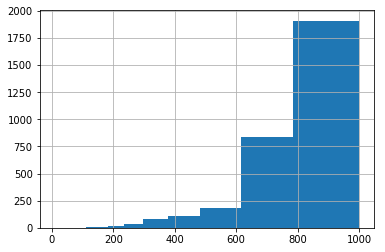

In [22]:
dfMPC = computeAllTheScores(df, dataset=datasetMPC, weights=weightsMPC)
dfMPC.singleScore.hist(bins=np.logspace(1,3,20))

                          F_e     Fk_mu    Fa_nu      F_c  new-close  \
son exc rat rho  id                                                    
1   1   3.0 21.0 4   0.491025  2.342941  1.35226  16490.0    0.00001   

                     old-close  new-open   clust_t           A_e     A_c  \
son exc rat rho  id                                                        
1   1   3.0 21.0 4    0.511297  0.000036  0.101976  5.175840e-11  6646.0   

                          ...        run_idx  beta_opt       D_e  singleScore  \
son exc rat rho  id       ...                                                   
1   1   3.0 21.0 4        ...              0      1.88  0.491025   121.089244   

                     medianObsScore  averageObsScore  weightAvgObsScore  \
son exc rat rho  id                                                       
1   1   3.0 21.0 4       534.240039       485.297364         485.297364   

                     medianScore  averageScore  weightAvgScore  
son exc rat rho  id

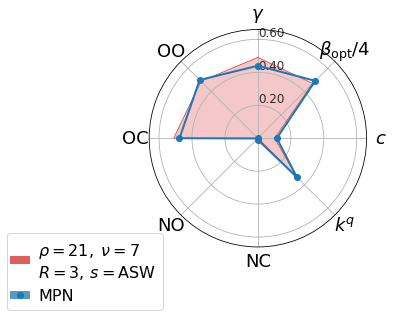

In [23]:
# "singleScore", "medianScore", "medianObsScore", "averageObsScore", "weightAvgObsScore"
scoreToUse = "singleScore"
indexSlice = 0

if False:
    # Select by hand
    r = dfMPC[dfMPC[scoreToUse] == dfMPC[scoreToUse].min()].iloc[indexSlice:indexSlice+1]#["Ev_Steps"]
else:
    # Pick the closest in the group
    gr = dfMPC[dfMPC[scoreToUse] == dfMPC[scoreToUse].min()].iloc[indexSlice:indexSlice+1]#["Ev_Steps"]
    rMPC = gr[gr["singleScore"] == gr["singleScore"].min()]
radarPlotDF(datasetMPC, rMPC, dataName="MPN",
          categoriesDict={
              "beta_opt": r"$\beta_{\rm opt}/4$", "D_e": r"$\gamma$",
              "clust_t": r"$c$", "k_a_t": r"$k^q$",
              "new-close": "NC", "new-open": "NO",
              "old-close": "OC", "old-open": "OO",
          },  rescaleDict={"beta_opt": 4.},
          yticks=np.arange(.2, .7, .2), additionalLabel="\n$R=3,\\,s=$ASW")
print rMPC
plt.savefig("radar_MPN.pdf", bbox_inches="tight")

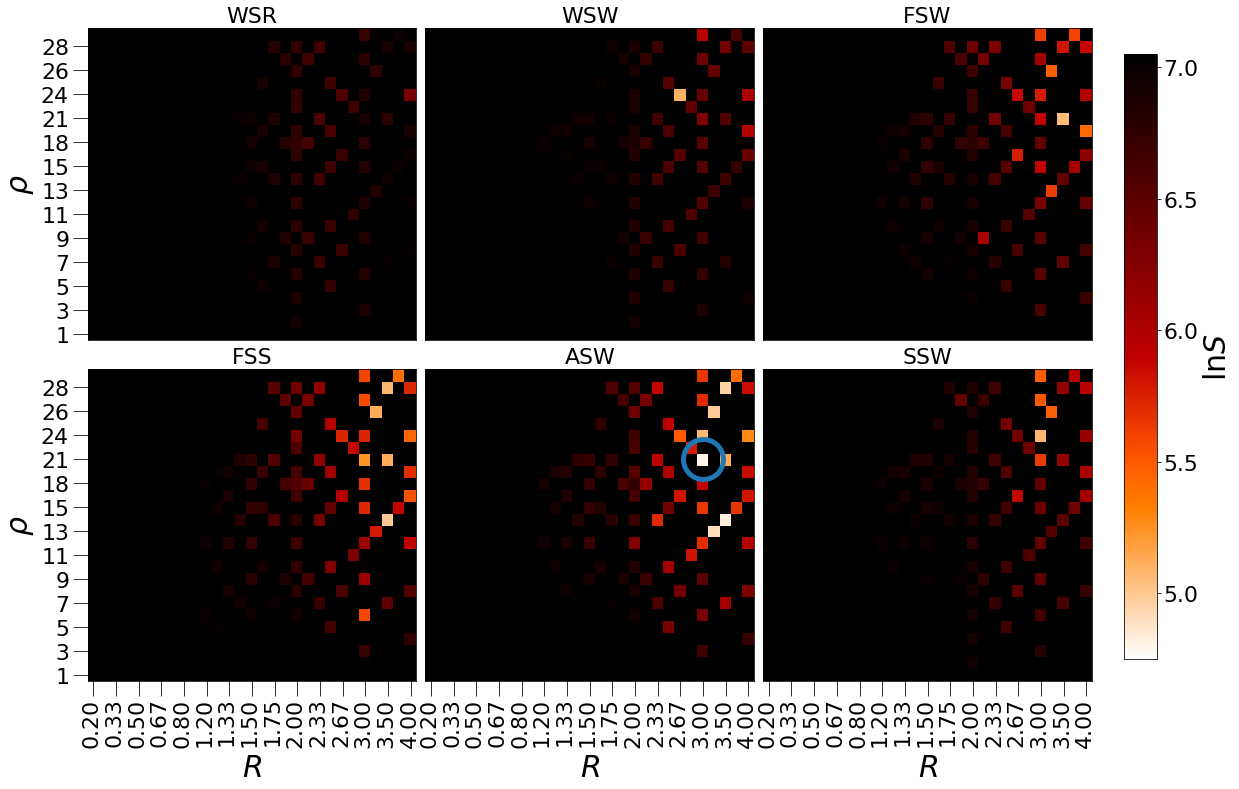

In [24]:
f = scoreHmapPlotDF(dfMPC, bestRow=rMPC, selectedScore=scoreToUse, vmin=4.75, vmax=7.05,
                  plotScale="log", cmap="gist_heat_r",
                  lw=.0, edgecolors="#ffffff")
plt.savefig("score_MPC.pdf", bbox_inches="tight")

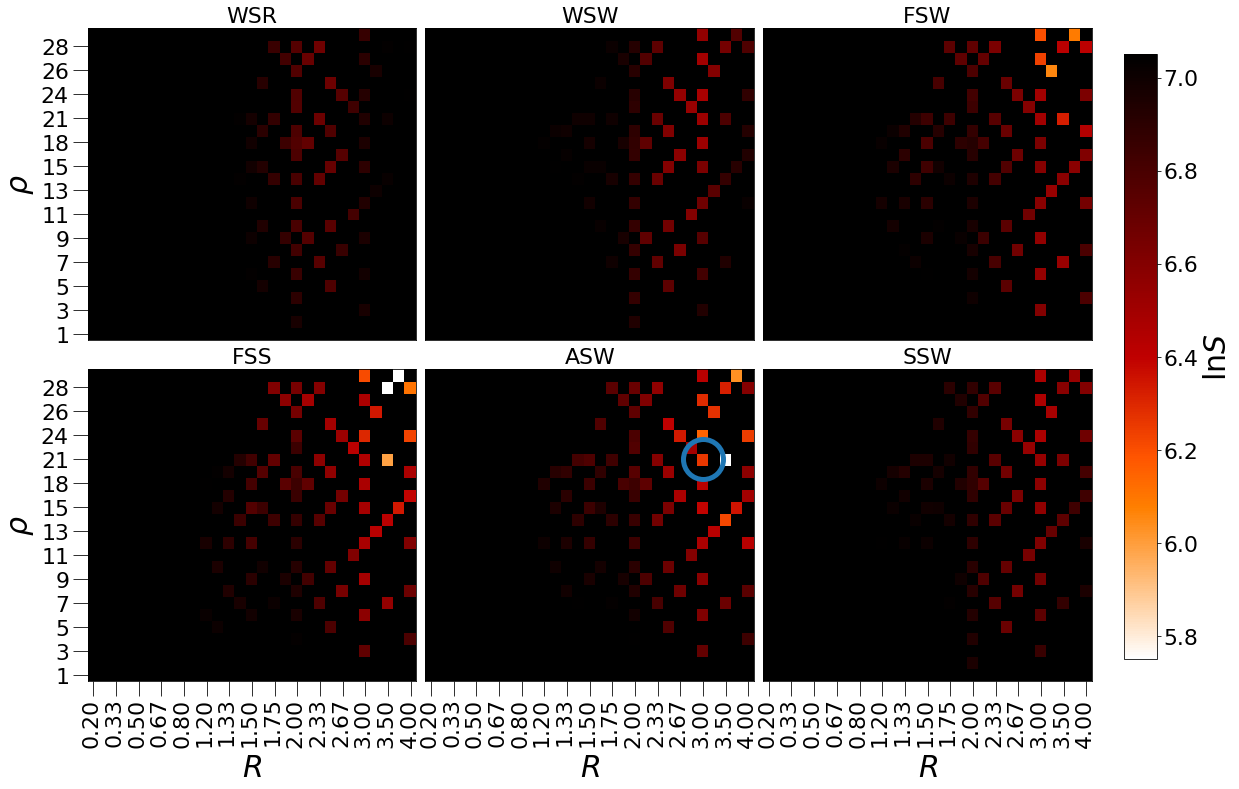

In [25]:
f = scoreHmapPlotDF(dfMPC, bestRow=rMPC, selectedScore="medianScore", vmin=5.75, vmax=7.05,
                  plotScale="log", cmap="gist_heat_r",
                  lw=.0, edgecolors="#ffffff")
#plt.savefig("score_TWT.pdf", bbox_inches="tight")

                          F_e     Fk_mu     Fa_nu      F_c  new-close  \
son exc rat rho  id                                                     
1   1   3.5 21.0 3   0.402138  2.238208  1.639316  15610.0    0.00001   

                     old-close  new-open   clust_t       A_e     A_c  \
son exc rat rho  id                                                    
1   1   3.5 21.0 3    0.735326  0.000026  0.117804  0.414606  6276.0   

                          ...        run_idx  beta_opt       D_e  singleScore  \
son exc rat rho  id       ...                                                   
1   1   3.5 21.0 3        ...              7      2.24  0.402138   378.407944   

                     medianObsScore  averageObsScore  weightAvgObsScore  \
son exc rat rho  id                                                       
1   1   3.5 21.0 3        258.27849       335.547392         335.547392   

                     medianScore  averageScore  weightAvgScore  
son exc rat rho  id         

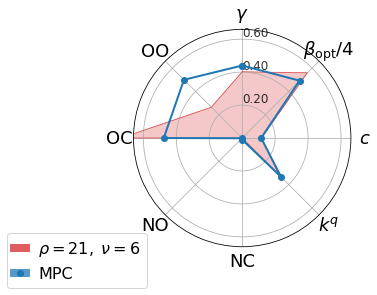

In [26]:
# "singleScore", "medianScore", "medianObsScore", "averageObsScore", "weightAvgObsScore"
indexSlice = 3

# Select by hand
r = dfMPC.loc[[(1,1,3.5,21,indexSlice)]]

radarPlotDF(datasetMPC, r, dataName="MPC",
          categoriesDict={
              "beta_opt": r"$\beta_{\rm opt}/4$", "D_e": r"$\gamma$",
              "clust_t": r"$c$", "k_a_t": r"$k^q$",
              "new-close": "NC", "new-open": "NO",
              "old-close": "OC", "old-open": "OO",
          },  rescaleDict={"beta_opt": 4.},
          yticks=np.arange(.2, .7, .2))
print r

# MPC Vito

In [27]:
selected_ratios = set(r for r in resultsGamma[0][0].keys() if r <= 4.)

In [28]:
#MPC
datasetMPCV = {
    "beta_opt": 1.9, "D_e": .46, "clust_t": .11, "k_a_t": .366,
    "old-open": .398, "old-close": .591, "new-open": .0065217, "new-close": .0034
          }

datasetMPC = {
    "beta_opt": 1.97, "D_e": .44, "clust_t": .115, "k_a_t": .335,
    "old-open": .50, "old-close": .476, "new-open": .00217, "new-close": .01
          }
if False:
    weightsMPCV = {
    "beta_opt": 1./.01, "D_e": 1./.01, "clust_t": 1./.0005, "k_a_t": 1./.04065,
    "old-open": 1./.00251, "old-close": 1./.0031, "new-open": 1./.000546, "new-close": 1./.000425,
          }
else:
    weightsMPCV = {
    "beta_opt": 1./.01, "D_e": 1./.01, "clust_t": 1./.0005, "k_a_t": 1./.04265,
    "old-open": 1./.00251, "old-close": 1./.0031, "new-open": 1./.000546, "new-close": 1./.000425,
          }

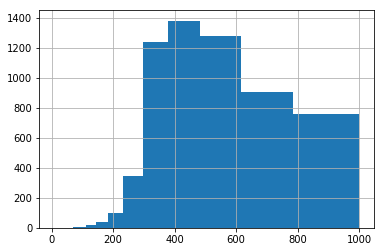

In [29]:
dfMPCV = computeAllTheScores(df, dataset=datasetMPCV, weights=weightsMPCV)
dfMPCV.singleScore.hist(bins=np.logspace(1,3,20))

                           F_e     Fk_mu     Fa_nu      F_c  new-close  \
son exc rat  rho  id                                                     
1   1   3.25 13.0 3   0.451583  2.231556  0.964957  17750.0   0.000015   

                      old-close  new-open   clust_t       A_e     A_c  \
son exc rat  rho  id                                                    
1   1   3.25 13.0 3    0.576406  0.000037  0.126428  0.470809  8142.0   

                           ...        run_idx  beta_opt       D_e  \
son exc rat  rho  id       ...                                      
1   1   3.25 13.0 3        ...              1      2.02  0.451583   

                      singleScore  medianObsScore  averageObsScore  \
son exc rat  rho  id                                                 
1   1   3.25 13.0 3     80.624644      403.721758       315.715888   

                      weightAvgObsScore  medianScore  averageScore  \
son exc rat  rho  id                                                

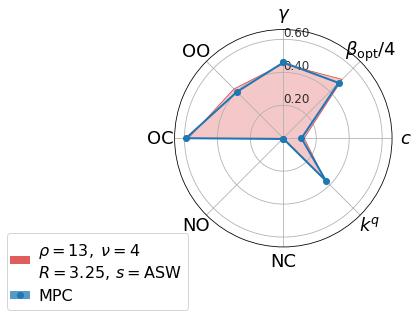

In [30]:
# "singleScore", "medianScore", "medianObsScore", "averageObsScore", "weightAvgObsScore"
scoreToUse = "singleScore"
indexSlice = 0

if False:
    # Select by hand
    r = dfMPCV[dfMPCV[scoreToUse] == dfMPCV[scoreToUse].min()].iloc[indexSlice:indexSlice+1]#["Ev_Steps"]
else:
    # Pick the closest in the group
    gr = dfMPCV[dfMPCV[scoreToUse] == dfMPCV[scoreToUse].min()].iloc[indexSlice:indexSlice+1]#["Ev_Steps"]
    rMPCV = gr[gr["singleScore"] == gr["singleScore"].min()]
radarPlotDF(datasetMPCV, rMPCV, dataName="MPC",
          categoriesDict={
              "beta_opt": r"$\beta_{\rm opt}/4$", "D_e": r"$\gamma$",
              "clust_t": r"$c$", "k_a_t": r"$k^q$",
              "new-close": "NC", "new-open": "NO",
              "old-close": "OC", "old-open": "OO",
          },  rescaleDict={"beta_opt": 4.},
          yticks=np.arange(.2, .7, .2), additionalLabel="\n$R=3.25,\\,s=$ASW")
print rMPCV
plt.savefig("radar_MPN_vit.pdf", bbox_inches="tight")

In [31]:
13/4.

3.25

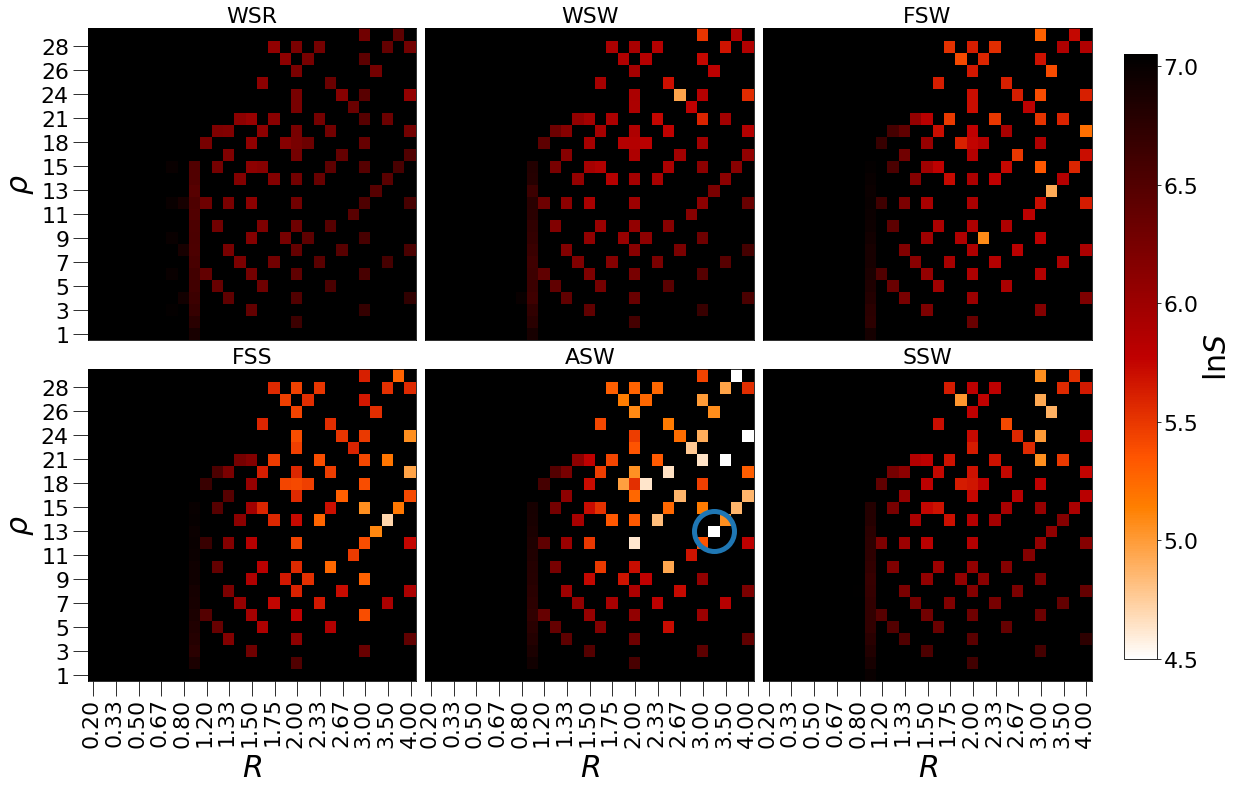

In [32]:
f = scoreHmapPlotDF(dfMPCV, bestRow=rMPCV, selectedScore=scoreToUse, vmin=4.5, vmax=7.05,
                  plotScale="log", cmap="gist_heat_r",
                  lw=.0, edgecolors="#ffffff")
plt.savefig("score_MPN_vit.pdf", bbox_inches="tight")

                          F_e     Fk_mu     Fa_nu     F_c  new-close  \
son exc rat rho  id                                                    
1   1   3.5 21.0 0   0.399061  2.232927  1.399782  8322.0    0.00001   

                     old-close  new-open  clust_t       A_e     A_c  \
son exc rat rho  id                                                   
1   1   3.5 21.0 0    0.574982  0.000017  0.11149  0.418236  3654.0   

                          ...        run_idx  beta_opt       D_e  singleScore  \
son exc rat rho  id       ...                                                   
1   1   3.5 21.0 0        ...              4      2.38  0.399061     94.90436   

                     medianObsScore  averageObsScore  weightAvgObsScore  \
son exc rat rho  id                                                       
1   1   3.5 21.0 0       111.282259        159.15409          159.15409   

                     medianScore  averageScore  weightAvgScore  
son exc rat rho  id               

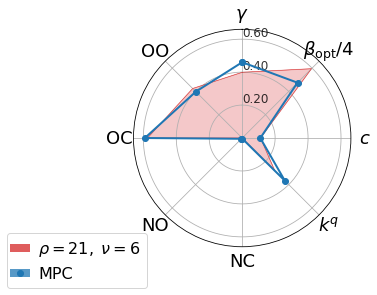

In [33]:
# "singleScore", "medianScore", "medianObsScore", "averageObsScore", "weightAvgObsScore"
indexSlice = 0

# Select by hand
r = dfMPCV.loc[[(1,1,3.5,21,indexSlice)]]

radarPlotDF(datasetMPCV, r, dataName="MPC",
          categoriesDict={
              "beta_opt": r"$\beta_{\rm opt}/4$", "D_e": r"$\gamma$",
              "clust_t": r"$c$", "k_a_t": r"$k^q$",
              "new-close": "NC", "new-open": "NO",
              "old-close": "OC", "old-open": "OO",
          },  rescaleDict={"beta_opt": 4.},
          yticks=np.arange(.2, .7, .2))
print r

# APS '70

Assortativity:
- REAL 
        total  (0.029943075100790032, 0.00020769198109543078)
        scalar (0.08954589052980869, 0.0013865760313083583)
- URNS
        total  (-0.06493816864240032, 0.0004565823918222975)
        scalar (0.06480235105158962, 0.0027818843220263198)

In [48]:
selected_ratios = set(r for r in resultsGamma[0][0].keys() if r <= 2.5)

In [49]:
# APS70
datasetAPS70 = {
    "beta_opt": .155, "D_e": .98, "clust_t": .44, "k_a_t": .465,
    "old-open": .052, "old-close": .35, "new-open": .485, "new-close": .10
          }

weightsAPS = {
    "beta_opt": 1./.01, "clust_t": 1./.0038, "D_e": 1./.0025, "k_a_t": 1./.0107,
    "old-open": 1./.0085, "old-close": 1./.0151, "new-open": 1./.0258, "new-close": 1./.016,
          }

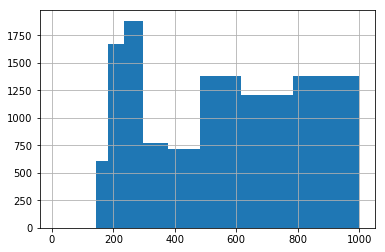

In [50]:
dfAPS70 = computeAllTheScores(df, dataset=datasetAPS70, weights=weightsAPS70)
dfAPS70.singleScore.hist(bins=np.logspace(1,3,20))

                         F_e     Fk_mu     Fa_nu        F_c  new-close  \
son exc rat rho id                                                       
1   2   0.4 6.0 5   0.996587  2.500731  2.302377  2002000.0   0.102139   

                    old-close  new-open   clust_t       A_e       A_c  ...  \
son exc rat rho id                                                     ...   
1   2   0.4 6.0 5    0.085263  0.600257  0.070829  0.999197  702700.0  ...   

                    run_idx  beta_opt       D_e  singleScore  medianObsScore  \
son exc rat rho id                                                             
1   2   0.4 6.0 5         5      0.18  0.996587   148.501849      150.659648   

                    averageObsScore  weightAvgObsScore  medianScore  \
son exc rat rho id                                                    
1   2   0.4 6.0 5        151.346856         151.346856    151.86696   

                    averageScore  weightAvgScore  
son exc rat rho id                  

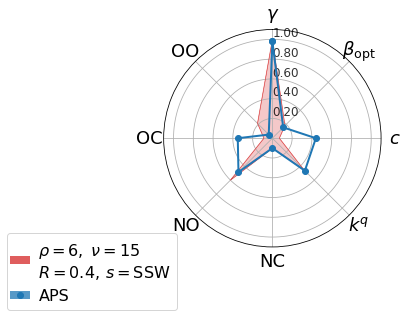

In [53]:
scoreToUse = "singleScore"
indexSlice = 0

if False:
    # Select by hand
    r = dfAPS70[dfAPS70[scoreToUse] == dfAPS70[scoreToUse].min()].iloc[indexSlice:indexSlice+1]#["Ev_Steps"]
else:
    # Pick the closest in the group
    gr = dfAPS70[dfAPS70[scoreToUse] == dfAPS70[scoreToUse].min()].iloc[indexSlice:indexSlice+1]#["Ev_Steps"]
    rAPS70 = gr[gr["singleScore"] == gr["singleScore"].min()]
radarPlotDF(datasetAPS70, rAPS70, dataName="APS",
          categoriesDict={
              "beta_opt": r"$\beta_{\rm opt}$", "D_e": r"$\gamma$",
              "clust_t": r"$c$", "k_a_t": r"$k^q$",
              "new-close": "NC", "new-open": "NO",
              "old-close": "OC", "old-open": "OO",
          }, yticks=np.arange(.2, 1.1, .2), additionalLabel="\n$R=0.4,\\,s=$SSW")
print rAPS70
plt.savefig("radar_APS70.pdf", bbox_inches="tight")

In [122]:
print " & ".join(["%.03f" % v for v in 
            rAPS70[["D_e", "beta_opt", "clust_t", "k_a_t", "new-close", "new-open", "old-close", "old-open"]].iloc[0]])
print " & ".join(["%.03f" % datasetAPS70[v] for v in 
            ["D_e", "beta_opt", "clust_t", "k_a_t", "new-close", "new-open", "old-close", "old-open"] ])

0.997 & 0.180 & 0.071 & 0.452 & 0.102 & 0.600 & 0.085 & 0.212
0.980 & 0.155 & 0.440 & 0.465 & 0.100 & 0.485 & 0.350 & 0.052


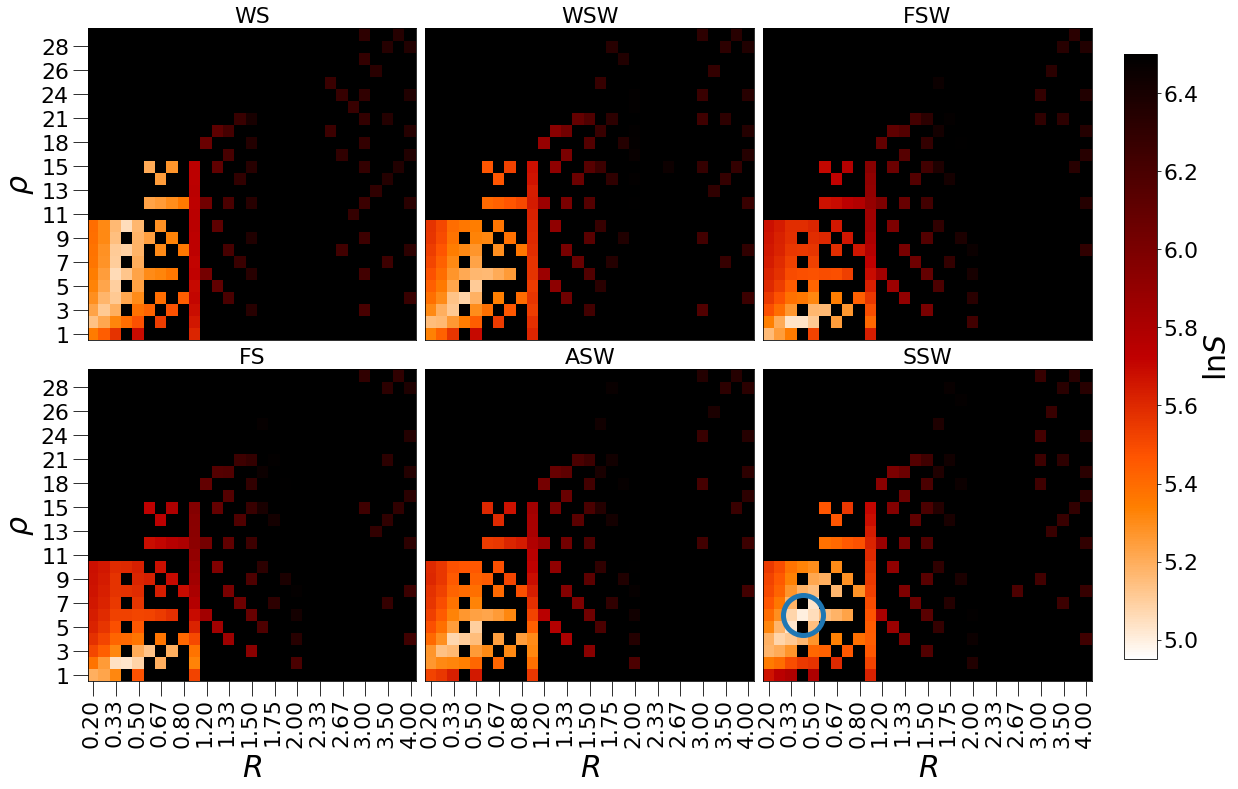

In [54]:
f = scoreHmapPlotDF(dfAPS70, bestRow=rAPS70, selectedScore=scoreToUse, vmin=4.95, vmax=6.5,
                  plotScale="log", cmap="gist_heat_r",
                  lw=.0, edgecolors="#ffffff")
plt.savefig("score_APS70.pdf", bbox_inches="tight")

# APS '70 SAMPLES

Assortativity:
- REAL 
        total  (0.029943075100790032, 0.00020769198109543078)
        scalar (0.08954589052980869, 0.0013865760313083583)
- URNS
        total  (-0.06493816864240032, 0.0004565823918222975)
        scalar (0.06480235105158962, 0.0027818843220263198)

## 1 sampled links

In [19]:
selected_ratios = set(r for r in resultsGamma[0][0].keys() if r <= 2.5)

In [20]:
# APS70 1 link
datasetAPS70_sample01 = {
    "beta_opt": .08, "D_e": .998, "clust_t": .034029, "k_a_t": .3868,
    "old-open": .2012, "old-close": .065435, "new-open": .66095, "new-close": .0728610
          }


weightsAPS70_sample01 = {
    "beta_opt": 1./.01, "clust_t": 1./.0091238, "D_e": 1./.0025, "k_a_t": 1./.005,
    "old-open": 1./.01027585, "old-close": 1./.008067151, "new-open": 1./.01728, "new-close": 1./.00919711,
          }

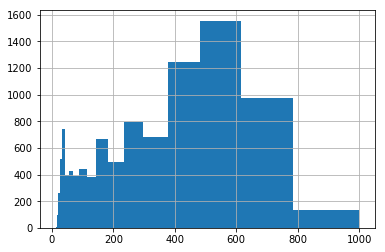

In [21]:
dfAPS70_sample01 = computeAllTheScores(df, dataset=datasetAPS70_sample01, weights=weightsAPS70_sample01)
dfAPS70_sample01.singleScore.hist(bins=np.logspace(1,3,20))

                              F_e     Fk_mu     Fa_nu        F_c  new-close  \
son exc rat      rho id                                                       
1   1   0.333333 5.0 3   0.997657  2.530479  2.330815  2082000.0    0.07769   

                         old-close  new-open   clust_t       A_e       A_c  \
son exc rat      rho id                                                      
1   1   0.333333 5.0 3    0.047528  0.677842  0.052941  0.999758  755800.0   

                         ...  run_idx  beta_opt       D_e  singleScore  \
son exc rat      rho id  ...                                             
1   1   0.333333 5.0 3   ...        1      0.14  0.997657     13.98294   

                         medianObsScore  averageObsScore  weightAvgObsScore  \
son exc rat      rho id                                                       
1   1   0.333333 5.0 3        15.685644        15.528265          15.528265   

                         medianScore  averageScore  weightAvgScore

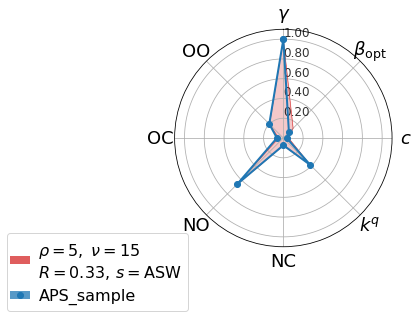

In [22]:
scoreToUse = "singleScore"
indexSlice = 0

if False:
    # Select by hand
    r = dfAPS70[dfAPS70[scoreToUse] == dfAPS70[scoreToUse].min()].iloc[indexSlice:indexSlice+1]#["Ev_Steps"]
else:
    # Pick the closest in the group
    gr = dfAPS70_sample01[dfAPS70_sample01[scoreToUse] == dfAPS70_sample01[scoreToUse].min()].iloc[indexSlice:indexSlice+1]#["Ev_Steps"]
    rAPS70_sample01 = gr[gr["singleScore"] == gr["singleScore"].min()]
radarPlotDF(datasetAPS70_sample01, rAPS70_sample01, dataName="APS_sample",
          categoriesDict={
              "beta_opt": r"$\beta_{\rm opt}$", "D_e": r"$\gamma$",
              "clust_t": r"$c$", "k_a_t": r"$k^q$",
              "new-close": "NC", "new-open": "NO",
              "old-close": "OC", "old-open": "OO",
          }, yticks=np.arange(.2, 1.1, .2), additionalLabel="\n$R=0.33,\\,s=$ASW")
print rAPS70_sample01
plt.savefig("radar_APS70_sample01.pdf", bbox_inches="tight")

In [108]:
print rAPS70_sample01.columns

Index([u'F_e', u'Fk_mu', u'Fa_nu', u'F_c', u'new-close', u'old-close',
       u'new-open', u'clust_t', u'A_e', u'A_c', u'Ev_Steps', u'p_to_f',
       u'old-open', u'D_c', u'k_a_t', u'run_idx', u'beta_opt', u'D_e',
       u'singleScore', u'medianObsScore', u'averageObsScore',
       u'weightAvgObsScore', u'medianScore', u'averageScore',
       u'weightAvgScore'],
      dtype='object')


In [123]:
print " & ".join(["%.03f" % v for v in 
            rAPS70_sample01[["A_e", "beta_opt", "clust_t", "k_a_t", "new-close", "new-open", "old-close", "old-open"]].iloc[0]])
print " & ".join(["%.03f" % datasetAPS70_sample01[v] for v in 
            ["D_e", "beta_opt", "clust_t", "k_a_t", "new-close", "new-open", "old-close", "old-open"] ])

1.000 & 0.140 & 0.053 & 0.379 & 0.078 & 0.678 & 0.048 & 0.197
0.998 & 0.080 & 0.034 & 0.387 & 0.073 & 0.661 & 0.065 & 0.201


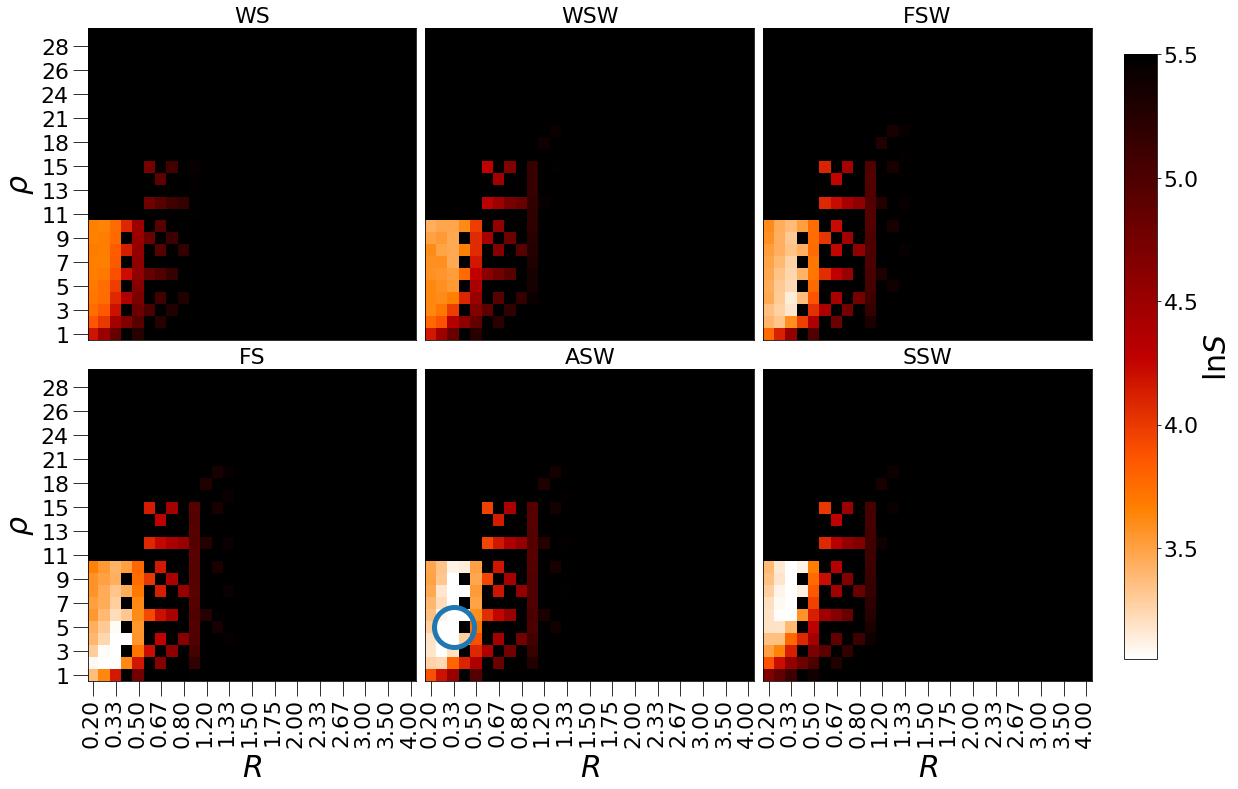

In [23]:
f = scoreHmapPlotDF(dfAPS70_sample01, bestRow=rAPS70_sample01, selectedScore=scoreToUse,
                  vmin=3.05, vmax=5.5,
                  plotScale="log", cmap="gist_heat_r",
                  lw=.0, edgecolors="#ffffff")
plt.savefig("score_APS70_sample01.pdf", bbox_inches="tight")

## 2 sampled links

In [27]:
selected_ratios = set(r for r in resultsGamma[0][0].keys() if r <= 2.5)

In [28]:
# APS70 2 link
datasetAPS70_sample02 = {
    "beta_opt": .09, "D_e": .998, "clust_t": .077364029, "k_a_t": .3449,
    "old-open": .2002, "old-close": .1142, "new-open": .5940, "new-close": .091
          }


weightsAPS70_sample02 = {
    "beta_opt": 1./.01, "clust_t": 1./.0091238, "D_e": 1./.0025, "k_a_t": 1./.0445,
    "old-open": 1./.01456, "old-close": 1./.01525, "new-open": 1./.01928, "new-close": 1./.01251,
          }


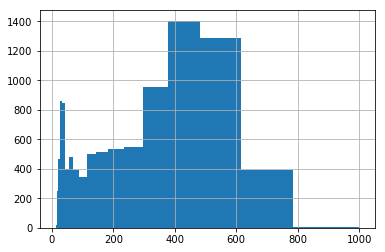

In [29]:
dfAPS70_sample02 = computeAllTheScores(df, dataset=datasetAPS70_sample02, weights=weightsAPS70_sample02)
dfAPS70_sample02.singleScore.hist(bins=np.logspace(1,3,20))

                         F_e    Fk_mu     Fa_nu        F_c  new-close  \
son exc rat rho id                                                      
1   1   0.4 4.0 8   0.998076  2.48352  2.286197  1850000.0   0.107116   

                    old-close  new-open   clust_t      A_e       A_c  ...  \
son exc rat rho id                                                    ...   
1   1   0.4 4.0 8    0.083475  0.594295  0.076839  1.00025  701600.0  ...   

                    run_idx  beta_opt       D_e  singleScore  medianObsScore  \
son exc rat rho id                                                             
1   1   0.4 4.0 8         0      0.18  0.998076    14.217301       14.848911   

                    averageObsScore  weightAvgObsScore  medianScore  \
son exc rat rho id                                                    
1   1   0.4 4.0 8         14.677582          14.677582    15.048882   

                    averageScore  weightAvgScore  
son exc rat rho id                        

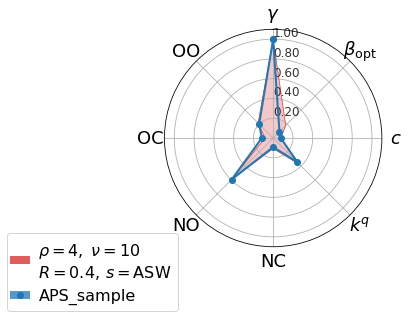

In [30]:
scoreToUse = "singleScore"
indexSlice = 0

if False:
    # Select by hand
    r = dfAPS70[dfAPS70[scoreToUse] == dfAPS70[scoreToUse].min()].iloc[indexSlice:indexSlice+1]#["Ev_Steps"]
else:
    # Pick the closest in the group
    gr = dfAPS70_sample02[dfAPS70_sample02[scoreToUse] == dfAPS70_sample02[scoreToUse].min()].iloc[indexSlice:indexSlice+1]#["Ev_Steps"]
    rAPS70_sample02 = gr[gr["singleScore"] == gr["singleScore"].min()]
radarPlotDF(datasetAPS70_sample02, rAPS70_sample02, dataName="APS_sample",
          categoriesDict={
              "beta_opt": r"$\beta_{\rm opt}$", "D_e": r"$\gamma$",
              "clust_t": r"$c$", "k_a_t": r"$k^q$",
              "new-close": "NC", "new-open": "NO",
              "old-close": "OC", "old-open": "OO",
          }, yticks=np.arange(.2, 1.1, .2), additionalLabel="\n$R=0.4,\\,s=$ASW")
print rAPS70_sample02
plt.savefig("radar_APS70_sample02.pdf", bbox_inches="tight")

In [124]:
print " & ".join(["%.03f" % v for v in 
            rAPS70_sample02[["A_e", "beta_opt", "clust_t", "k_a_t", "new-close", "new-open", "old-close", "old-open"]].iloc[0]])
print " & ".join(["%.03f" % datasetAPS70_sample02[v] for v in 
            ["D_e", "beta_opt", "clust_t", "k_a_t", "new-close", "new-open", "old-close", "old-open"] ])

1.000 & 0.180 & 0.077 & 0.380 & 0.107 & 0.594 & 0.083 & 0.215
0.998 & 0.090 & 0.077 & 0.345 & 0.091 & 0.594 & 0.114 & 0.200


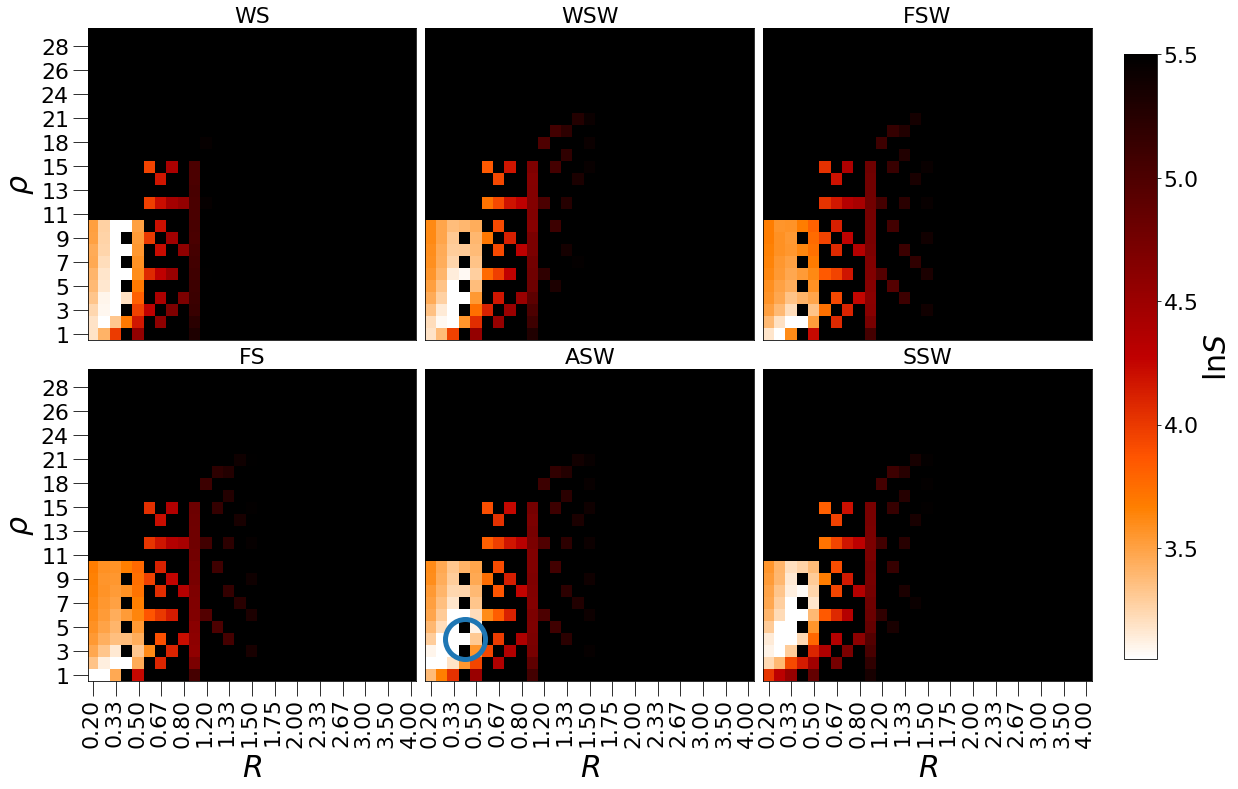

In [31]:
f = scoreHmapPlotDF(dfAPS70_sample02, bestRow=rAPS70_sample02, selectedScore=scoreToUse,
                  vmin=3.05, vmax=5.5,
                  plotScale="log", cmap="gist_heat_r",
                  lw=.0, edgecolors="#ffffff")
plt.savefig("score_APS70_sample02.pdf", bbox_inches="tight")

## 3 sampled links

In [32]:
selected_ratios = set(r for r in resultsGamma[0][0].keys() if r <= 2.5)

In [33]:
# APS70 2 link
datasetAPS70_sample03 = {
    "beta_opt": .15, "D_e": .998, "clust_t": .133029, "k_a_t": .4103868,
    "old-open": .1722, "old-close": .15545, "new-open": .57265, "new-close": .1008610
          }


weightsAPS70_sample03 = {
    "beta_opt": 1./.01, "clust_t": 1./.00291238, "D_e": 1./.0025, "k_a_t": 1./.149,
    "old-open": 1./.0148885, "old-close": 1./.0179651, "new-open": 1./.0209628, "new-close": 1./.01424919711,
          }


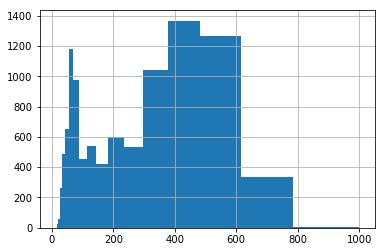

In [34]:
dfAPS70_sample03 = computeAllTheScores(df, dataset=datasetAPS70_sample03, weights=weightsAPS70_sample03)
dfAPS70_sample03.singleScore.hist(bins=np.logspace(1,3,20))

                         F_e     Fk_mu     Fa_nu        F_c  new-close  \
son exc rat rho id                                                       
1   1   0.4 2.0 4   0.996995  2.388446  2.235768  1614000.0   0.188681   

                    old-close  new-open  clust_t      A_e       A_c  ...  \
son exc rat rho id                                                   ...   
1   1   0.4 2.0 4    0.152106  0.480519  0.12874  1.00093  668900.0  ...   

                    run_idx  beta_opt       D_e  singleScore  medianObsScore  \
son exc rat rho id                                                             
1   1   0.4 2.0 4         4      0.19  0.996995    17.090279       19.448563   

                    averageObsScore  weightAvgObsScore  medianScore  \
son exc rat rho id                                                    
1   1   0.4 2.0 4         19.303549          19.303549    19.506639   

                    averageScore  weightAvgScore  
son exc rat rho id                        

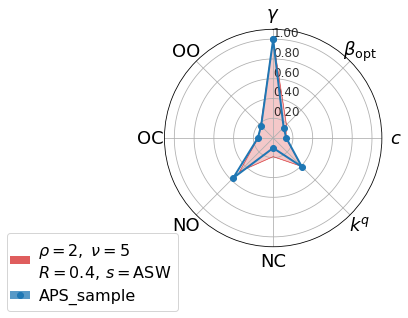

In [35]:
scoreToUse = "singleScore"
indexSlice = 0

if False:
    # Select by hand
    r = dfAPS70[dfAPS70[scoreToUse] == dfAPS70[scoreToUse].min()].iloc[indexSlice:indexSlice+1]#["Ev_Steps"]
else:
    # Pick the closest in the group
    gr = dfAPS70_sample03[dfAPS70_sample03[scoreToUse] == dfAPS70_sample03[scoreToUse].min()].iloc[indexSlice:indexSlice+1]#["Ev_Steps"]
    rAPS70_sample03 = gr[gr["singleScore"] == gr["singleScore"].min()]
radarPlotDF(datasetAPS70_sample03, rAPS70_sample03, dataName="APS_sample",
          categoriesDict={
              "beta_opt": r"$\beta_{\rm opt}$", "D_e": r"$\gamma$",
              "clust_t": r"$c$", "k_a_t": r"$k^q$",
              "new-close": "NC", "new-open": "NO",
              "old-close": "OC", "old-open": "OO",
          }, yticks=np.arange(.2, 1.1, .2), additionalLabel="\n$R=0.4,\\,s=$ASW")
print rAPS70_sample03
plt.savefig("radar_APS70_sample03.pdf", bbox_inches="tight")

In [126]:
print " & ".join(["%.03f" % v for v in 
            rAPS70_sample03[["A_e", "beta_opt", "clust_t", "k_a_t", "new-close", "new-open", "old-close", "old-open"]].iloc[0]])
print " & ".join(["%.03f" % datasetAPS70_sample03[v] for v in 
            ["D_e", "beta_opt", "clust_t", "k_a_t", "new-close", "new-open", "old-close", "old-open"] ])

1.001 & 0.190 & 0.129 & 0.405 & 0.189 & 0.481 & 0.152 & 0.179
0.998 & 0.150 & 0.133 & 0.410 & 0.101 & 0.573 & 0.155 & 0.172


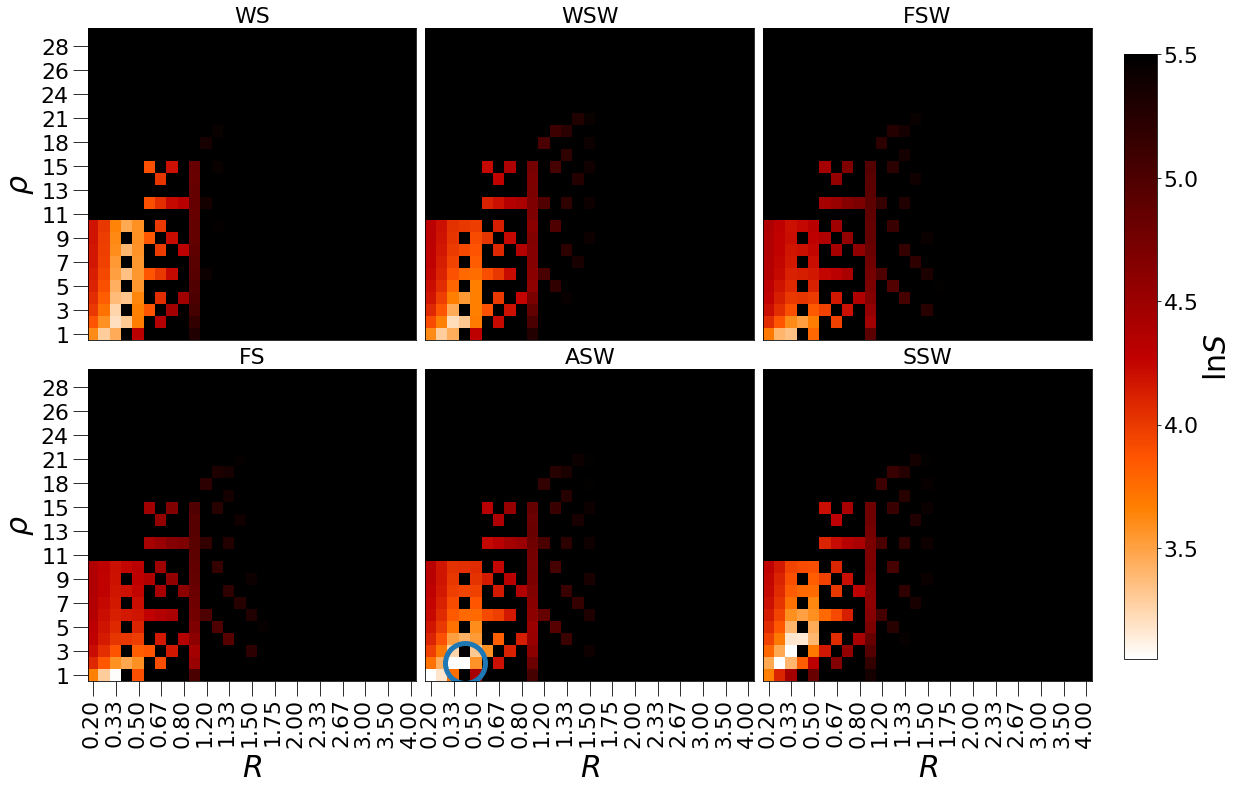

In [36]:
f = scoreHmapPlotDF(dfAPS70_sample03, bestRow=rAPS70_sample03, selectedScore=scoreToUse,
                  vmin=3.05, vmax=5.5,
                  plotScale="log", cmap="gist_heat_r",
                  lw=.0, edgecolors="#ffffff")
plt.savefig("score_APS70_sample03.pdf", bbox_inches="tight")

## 4 sampled links

In [37]:
selected_ratios = set(r for r in resultsGamma[0][0].keys() if r <= 2.5)

In [38]:
# APS70 2 link
datasetAPS70_sample04 = {
    "beta_opt": .13, "D_e": .998, "clust_t": .179, "k_a_t": .37903868,
    "old-open": .153, "old-close": .183, "new-open": .560, "new-close": .1028610
          }


weightsAPS70_sample04 = {
    "beta_opt": 1./.01, "clust_t": 1./.0062238, "D_e": 1./.0025, "k_a_t": 1./.06,
    "old-open": 1./.0148885, "old-close": 1./.020651, "new-open": 1./.023028, "new-close": 1./.015189711,
          }


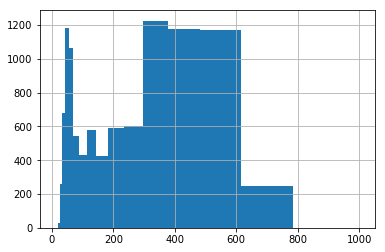

In [39]:
dfAPS70_sample04 = computeAllTheScores(df, dataset=datasetAPS70_sample04, weights=weightsAPS70_sample04)
dfAPS70_sample04.singleScore.hist(bins=np.logspace(1,3,20))

                              F_e     Fk_mu     Fa_nu        F_c  new-close  \
son exc rat      rho id                                                       
1   1   0.333333 2.0 4   0.998912  2.415266  2.271618  1804000.0   0.175955   

                         old-close  new-open   clust_t      A_e       A_c  \
son exc rat      rho id                                                     
1   1   0.333333 2.0 4    0.109223  0.548699  0.111348  1.00018  724600.0   

                         ...  run_idx  beta_opt       D_e  singleScore  \
son exc rat      rho id  ...                                             
1   1   0.333333 2.0 4   ...        4      0.16  0.998912    24.397708   

                         medianObsScore  averageObsScore  weightAvgObsScore  \
son exc rat      rho id                                                       
1   1   0.333333 2.0 4        24.699767        24.666193          24.666193   

                         medianScore  averageScore  weightAvgScore  


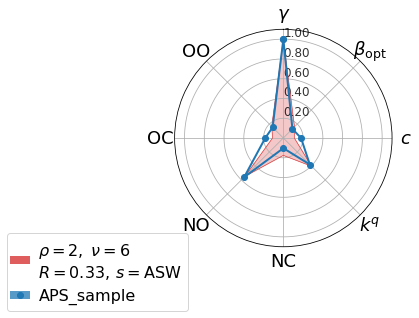

In [40]:
scoreToUse = "singleScore"
indexSlice = 0

if False:
    # Select by hand
    r = dfAPS70[dfAPS70[scoreToUse] == dfAPS70[scoreToUse].min()].iloc[indexSlice:indexSlice+1]#["Ev_Steps"]
else:
    # Pick the closest in the group
    gr = dfAPS70_sample04[dfAPS70_sample04[scoreToUse] == dfAPS70_sample04[scoreToUse].min()].iloc[indexSlice:indexSlice+1]#["Ev_Steps"]
    rAPS70_sample04 = gr[gr["singleScore"] == gr["singleScore"].min()]
radarPlotDF(datasetAPS70_sample04, rAPS70_sample04, dataName="APS_sample",
          categoriesDict={
              "beta_opt": r"$\beta_{\rm opt}$", "D_e": r"$\gamma$",
              "clust_t": r"$c$", "k_a_t": r"$k^q$",
              "new-close": "NC", "new-open": "NO",
              "old-close": "OC", "old-open": "OO",
          }, yticks=np.arange(.2, 1.1, .2), additionalLabel="\n$R=0.33,\\,s=$ASW")
print rAPS70_sample04
plt.savefig("radar_APS70_sample04.pdf", bbox_inches="tight")

In [127]:
print " & ".join(["%.03f" % v for v in 
            rAPS70_sample04[["A_e", "beta_opt", "clust_t", "k_a_t", "new-close", "new-open", "old-close", "old-open"]].iloc[0]])
print " & ".join(["%.03f" % datasetAPS70_sample04[v] for v in 
            ["D_e", "beta_opt", "clust_t", "k_a_t", "new-close", "new-open", "old-close", "old-open"] ])

1.000 & 0.160 & 0.111 & 0.403 & 0.176 & 0.549 & 0.109 & 0.166
0.998 & 0.130 & 0.179 & 0.379 & 0.103 & 0.560 & 0.183 & 0.153


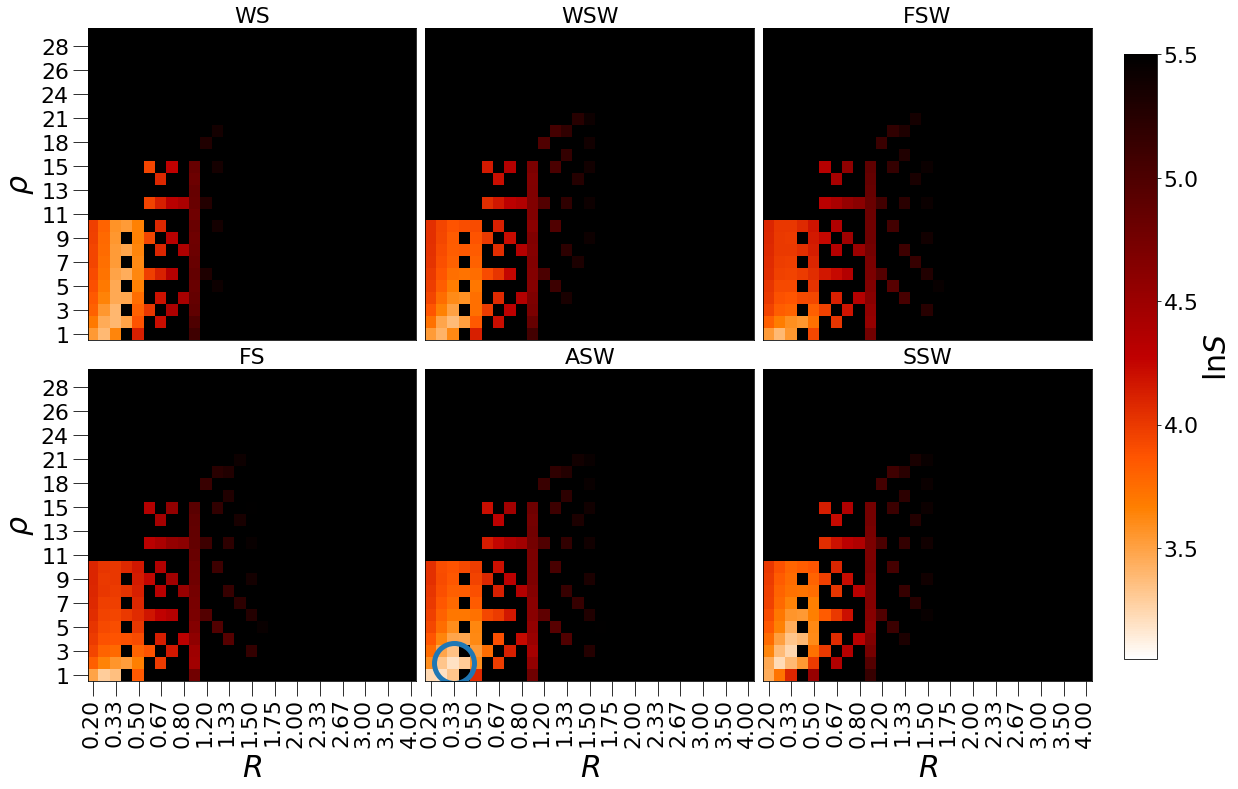

In [41]:
f = scoreHmapPlotDF(dfAPS70_sample04, bestRow=rAPS70_sample04, selectedScore=scoreToUse,
                  vmin=3.05, vmax=5.5,
                  plotScale="log", cmap="gist_heat_r",
                  lw=.0, edgecolors="#ffffff")
plt.savefig("score_APS70_sample04.pdf", bbox_inches="tight")

## 5 sampled links

In [42]:
selected_ratios = set(r for r in resultsGamma[0][0].keys() if r <= 2.5)

In [43]:
# APS70 2 link
datasetAPS70_sample05 = {
    "beta_opt": .13, "D_e": .998, "clust_t": .215, "k_a_t": .39908,
    "old-open": .1384, "old-close": .2060, "new-open": .5519, "new-close": .1035
          }


weightsAPS70_sample05 = {
    "beta_opt": 1./.01, "clust_t": 1./.0062238, "D_e": 1./.0025, "k_a_t": 1./.085,
    "old-open": 1./.0148885, "old-close": 1./.020651, "new-open": 1./.023028, "new-close": 1./.015189711,
          }


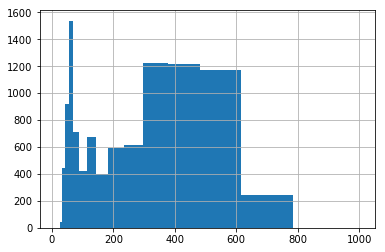

In [44]:
dfAPS70_sample05 = computeAllTheScores(df, dataset=datasetAPS70_sample05, weights=weightsAPS70_sample05)
dfAPS70_sample05.singleScore.hist(bins=np.logspace(1,3,20))

                          F_e     Fk_mu     Fa_nu        F_c  new-close  \
son exc rat  rho id                                                       
1   1   0.25 1.0 4   0.996112  2.350802  2.243873  1746000.0   0.252453   

                     old-close  new-open   clust_t      A_e       A_c  ...  \
son exc rat  rho id                                                    ...   
1   1   0.25 1.0 4    0.126844  0.496495  0.147855  1.00088  748700.0  ...   

                     run_idx  beta_opt       D_e  singleScore  medianObsScore  \
son exc rat  rho id                                                             
1   1   0.25 1.0 4         4      0.14  0.996112     29.71823       32.580919   

                     averageObsScore  weightAvgObsScore  medianScore  \
son exc rat  rho id                                                    
1   1   0.25 1.0 4         31.963338          31.963338    32.425304   

                     averageScore  weightAvgScore  
son exc rat  rho id       

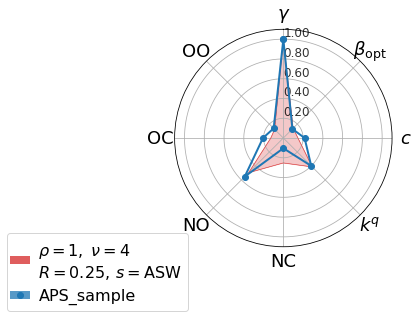

In [45]:
scoreToUse = "singleScore"
indexSlice = 0

if False:
    # Select by hand
    r = dfAPS70[dfAPS70[scoreToUse] == dfAPS70[scoreToUse].min()].iloc[indexSlice:indexSlice+1]#["Ev_Steps"]
else:
    # Pick the closest in the group
    gr = dfAPS70_sample05[dfAPS70_sample05[scoreToUse] == dfAPS70_sample05[scoreToUse].min()].iloc[indexSlice:indexSlice+1]#["Ev_Steps"]
    rAPS70_sample05 = gr[gr["singleScore"] == gr["singleScore"].min()]
radarPlotDF(datasetAPS70_sample05, rAPS70_sample05, dataName="APS_sample",
          categoriesDict={
              "beta_opt": r"$\beta_{\rm opt}$", "D_e": r"$\gamma$",
              "clust_t": r"$c$", "k_a_t": r"$k^q$",
              "new-close": "NC", "new-open": "NO",
              "old-close": "OC", "old-open": "OO",
          }, yticks=np.arange(.2, 1.1, .2), additionalLabel="\n$R=0.25,\\,s=$ASW")
print rAPS70_sample05
plt.savefig("radar_APS70_sample05.pdf", bbox_inches="tight")

In [128]:
print " & ".join(["%.03f" % v for v in 
            rAPS70_sample05[["A_e", "beta_opt", "clust_t", "k_a_t", "new-close", "new-open", "old-close", "old-open"]].iloc[0]])
print " & ".join(["%.03f" % datasetAPS70_sample05[v] for v in 
            ["D_e", "beta_opt", "clust_t", "k_a_t", "new-close", "new-open", "old-close", "old-open"] ])

1.001 & 0.140 & 0.148 & 0.414 & 0.252 & 0.496 & 0.127 & 0.124
0.998 & 0.130 & 0.215 & 0.399 & 0.103 & 0.552 & 0.206 & 0.138


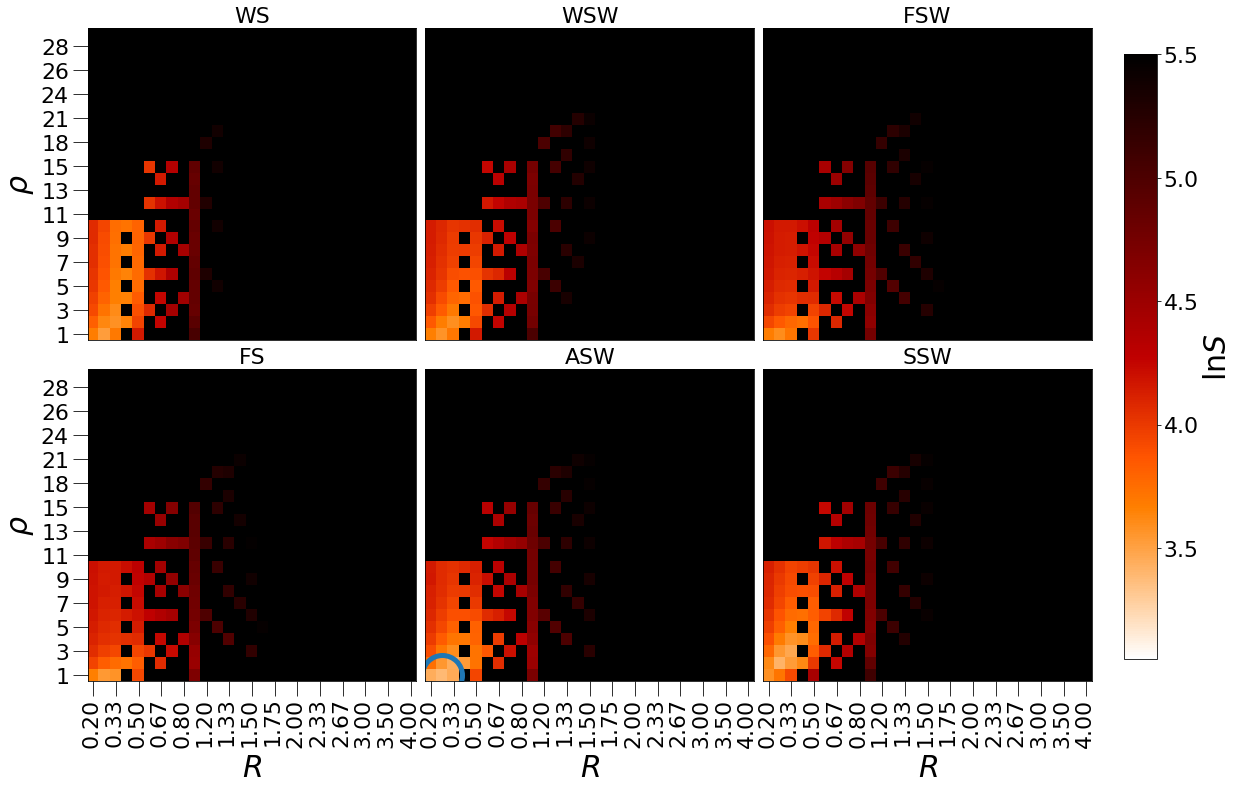

In [46]:
f = scoreHmapPlotDF(dfAPS70_sample05, bestRow=rAPS70_sample05, selectedScore=scoreToUse,
                  vmin=3.05, vmax=5.5,
                  plotScale="log", cmap="gist_heat_r",
                  lw=.0, edgecolors="#ffffff")
plt.savefig("score_APS70_sample05.pdf", bbox_inches="tight")

## 10 sampled links

In [14]:
selected_ratios = set(r for r in resultsGamma[0][0].keys() if r <= 2.5)

In [100]:
# APS70 2 link
# APS70
datasetAPS70 = {
    "beta_opt": .155, "D_e": .98, "clust_t": .44, "k_a_t": .465,
    "old-open": .052, "old-close": .35, "new-open": .485, "new-close": .10
          }

weightsAPS = {
    "beta_opt": 1./.01, "clust_t": 1./.0038, "D_e": 1./.0025, "k_a_t": 1./.0107,
    "old-open": 1./.0085, "old-close": 1./.0151, "new-open": 1./.0258, "new-close": 1./.016,
          }


datasetAPS70_sample10 = {
    "beta_opt": .14, "D_e": .99, "clust_t": .3276, "k_a_t": .4327,
    "old-open": .084240, "old-close": .30567, "new-open": .48315, "new-close": .126925,
          }


weightsAPS70_sample10 = {
    "beta_opt": 1./.01, "clust_t": 1./.00334, "D_e": 1./.0035, "k_a_t": 1./.1046,
    "old-open": 1./.0046, "old-close": 1./.0073, "new-open": 1./.01015, "new-close": 1./.00731,
          }


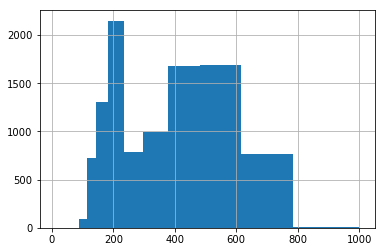

In [101]:
dfAPS70_sample10 = computeAllTheScores(df, dataset=datasetAPS70_sample10, weights=weightsAPS70_sample10)
dfAPS70_sample10.singleScore.hist(bins=np.logspace(1,3,20))

                              F_e     Fk_mu     Fa_nu        F_c  new-close  \
son exc rat      rho id                                                       
1   2   0.333333 1.0 0   0.988012  2.224743  2.111148  1335000.0    0.32264   

                         old-close  new-open   clust_t    A_e       A_c  ...  \
son exc rat      rho id                                                  ...   
1   2   0.333333 1.0 0    0.312148  0.268918  0.215834  1.005  589900.0  ...   

                         run_idx  beta_opt       D_e  singleScore  \
son exc rat      rho id                                             
1   2   0.333333 1.0 0         0      0.23  0.988012    95.709267   

                         medianObsScore  averageObsScore  weightAvgObsScore  \
son exc rat      rho id                                                       
1   2   0.333333 1.0 0       100.257796        99.216001          99.216001   

                         medianScore  averageScore  weightAvgScore  
son ex

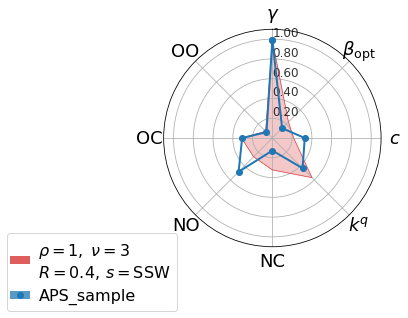

In [102]:
scoreToUse = "singleScore"
indexSlice = 0

if False:
    # Select by hand
    r = dfAPS70[dfAPS70[scoreToUse] == dfAPS70[scoreToUse].min()].iloc[indexSlice:indexSlice+1]#["Ev_Steps"]
else:
    # Pick the closest in the group
    gr = dfAPS70_sample10[dfAPS70_sample10[scoreToUse] == dfAPS70_sample10[scoreToUse].min()].iloc[indexSlice:indexSlice+1]#["Ev_Steps"]
    rAPS70_sample10 = gr[gr["singleScore"] == gr["singleScore"].min()]
radarPlotDF(datasetAPS70_sample10, rAPS70_sample10, dataName="APS_sample",
          categoriesDict={
              "beta_opt": r"$\beta_{\rm opt}$", "D_e": r"$\gamma$",
              "clust_t": r"$c$", "k_a_t": r"$k^q$",
              "new-close": "NC", "new-open": "NO",
              "old-close": "OC", "old-open": "OO",
          }, yticks=np.arange(.2, 1.1, .2), additionalLabel="\n$R=0.4,\\,s=$SSW")
print rAPS70_sample10
plt.savefig("radar_APS70_sample10.pdf", bbox_inches="tight")

In [129]:
print " & ".join(["%.03f" % v for v in 
            rAPS70_sample10[["A_e", "beta_opt", "clust_t", "k_a_t", "new-close", "new-open", "old-close", "old-open"]].iloc[0]])
print " & ".join(["%.03f" % datasetAPS70_sample10[v] for v in 
            ["D_e", "beta_opt", "clust_t", "k_a_t", "new-close", "new-open", "old-close", "old-open"] ])

1.005 & 0.230 & 0.216 & 0.568 & 0.323 & 0.269 & 0.312 & 0.096
0.990 & 0.140 & 0.328 & 0.433 & 0.127 & 0.483 & 0.306 & 0.084


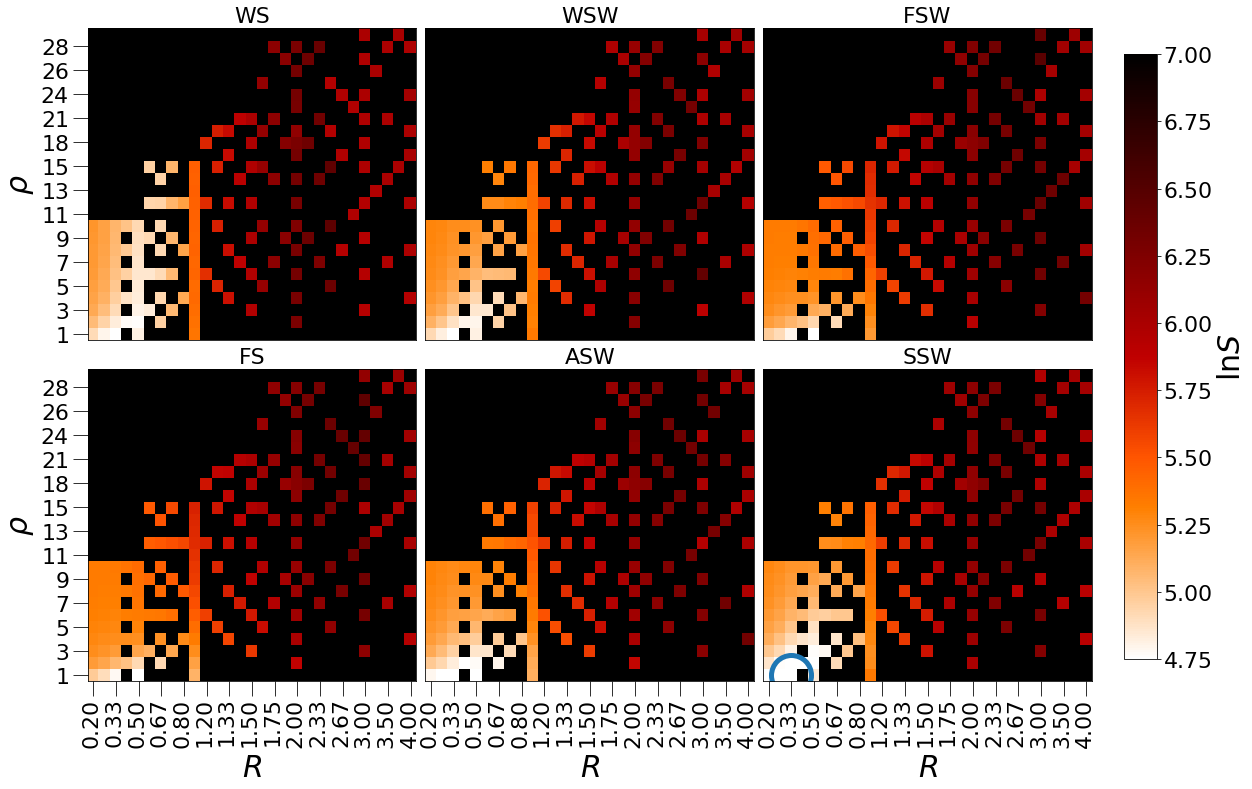

In [103]:
f = scoreHmapPlotDF(dfAPS70_sample10, bestRow=rAPS70_sample10, selectedScore=scoreToUse,
                  vmin=4.75, vmax=7.,
                  plotScale="log", cmap="gist_heat_r",
                  lw=.0, edgecolors="#ffffff")
plt.savefig("score_APS70_sample10.pdf", bbox_inches="tight")

# APS

In [220]:
selected_ratios = set(r for r in resultsGamma[0][0].keys() if r <= 2.5)

In [221]:
#APS
datasetAPS = {
    "beta_opt": .16, "D_e": .972, "clust_t": .445, "k_a_t": .5,
    "old-open": .052, "old-close": .343, "new-open": .508, "new-close": .0962
          }

weightsAPS = {
    "beta_opt": 1./.01, "clust_t": 1./.0038, "D_e": 1./.0025, "k_a_t": 1./.0107,
    "old-open": 1./.0085, "old-close": 1./.0151, "new-open": 1./.0258, "new-close": 1./.016,
          }

In [222]:
#weightsAPS = {k: 1./np.sqrt(v) for k, v in datasetAPS.iteritems()}

In [228]:
resAPS = score(resultsGamma, resultsBeta, dataset=datasetAPS,
      weights=weightsAPS, selectedRatios=selected_ratios)
print resAPS[-2:]

(102.16263822980405, {'sonExch': 1, 'schExch': 2, 'ratio': 0.3333333333333333, 'rho': 1.0})


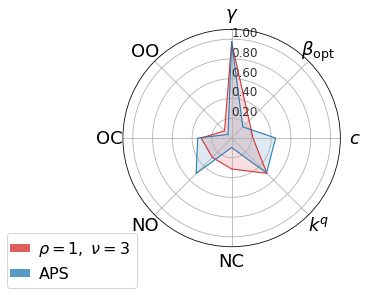

In [229]:
radarPlot(dataset=datasetAPS, res=resAPS,
          dataName="APS", yticks=np.arange(.2, 1.1, .2),
          categoriesDict={
              "beta_opt": r"$\beta_{\rm opt}$", "D_e": r"$\gamma$",
              "clust_t": r"$c$", "k_a_t": r"$k^q$",
              "new-close": "NC", "new-open": "NO",
              "old-close": "OC", "old-open": "OO",
          },
         )

plt.savefig("radar_APS.pdf", bbox_inches="tight")

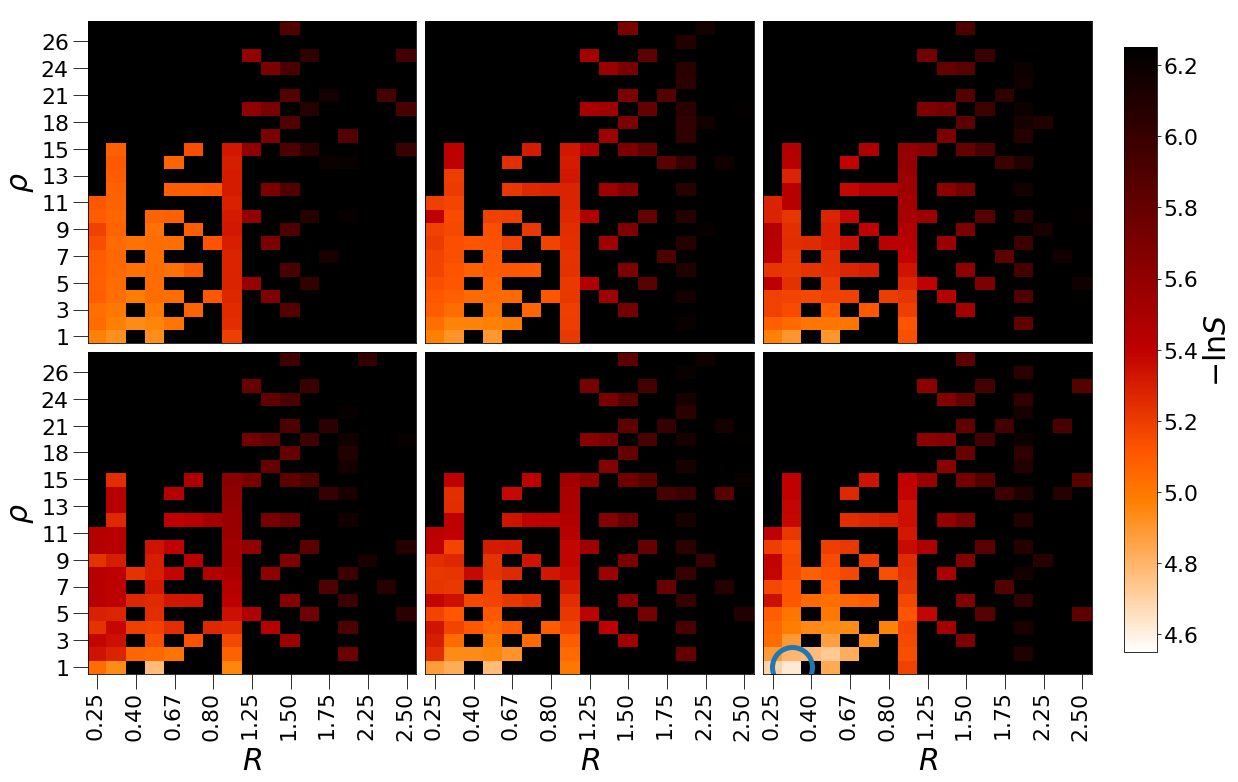

In [233]:
f = scoreHmapPlot(resAPS, vmin=4.55, vmax=6.25,
                  plotScale="log", cmap="gist_heat_r",
                  lw=.0, edgecolors="#ffffff")
plt.savefig("score_APS.pdf", bbox_inches="tight")

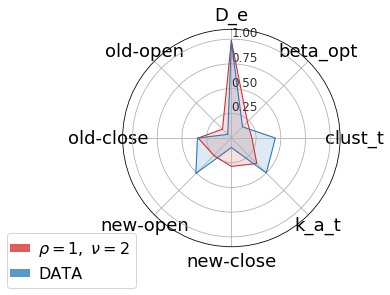

In [25]:
compareRadar(dataset=datasetAPS, res_tot=resAPS, son=1, sch=1, ratio=.5, rho=1.)

# Old version with dictionary

In [19]:
# Check missing keys...
keys = [set(), set()]
for iii, ddd in enumerate((resultsGamma, resultsBeta)):
    for sonKey, sonVal in ddd.iteritems():
        for excKey, excVal in sonVal.iteritems():
            for ratKey, ratVal in excVal.iteritems():
                for rho in ratVal.keys():
                    keys[iii].add((sonKey, excKey, ratKey, rho))
    

In [20]:
keys[0].symmetric_difference(keys[1])

set()

In [21]:
def Nu(rho, ratio):
    return int(rho/float(ratio))

def score(dataGamma, dataBeta, dataset, weights, selectedRatios=None, selectedTime=None):
    
    totRes, bestConf, bestScore, bestPars = {}, {}, 1e8, None
    
    for sonExch, sonData in dataGamma.iteritems():
        for schExch, schData in sonData.iteritems():
            for ratio, results_gamma in schData.iteritems():
                if selectedRatios and ratio not in selectedRatios: continue
                
                results_beta = dataBeta[sonExch][schExch][ratio]
                rhos = sorted(
                    list(
                        set(
                            results_gamma.keys()).intersection(set(results_beta.keys()))
                        )
                    )
                nus  = [Nu(rho=r, ratio=ratio) for r in rhos]
                
                
                for rho, nu in zip(rhos, nus):
                    if selectedTime:
                        max_time_gamma_idx = np.argmax(
                            np.array(results_gamma[rho]["Ev_Steps"]) == selectedTime)
                        max_time_beta_idx = np.argmax(
                            np.array(results_beta[rho]["Ev_Steps"]) == selectedTime)
                        
                    else:
                        max_time_gamma_idx = np.argmax(results_gamma[rho]["Ev_Steps"])
                        max_time_beta_idx = np.argmax(results_beta[rho]["Ev_Steps"])
                    #print results_beta[rho]["Ev_Steps"][max_time_beta_idx]
                    
                    score = 0
                    configuration = {}
                    for what, weight in weights.iteritems():
                        if what in (
                            'clust_t', "Fa_nu", "Fk_mu", 'beta_opt', "k_a_t",
                            'old-open', 'old-close', 'new-open', 'new-close',
                                    ):
                            if what == "k_a_t":
                                ref_val = results_beta[rho][what][max_time_beta_idx][-2]
                            else:
                                ref_val = results_beta[rho][what][max_time_beta_idx]
                        elif what in ('D_e',):
                            ref_val = results_gamma[rho][what][max_time_gamma_idx]
                        else:
                            raise RuntimeError, "String %s not in supported cases" % what
                            
                        score += np.abs(dataset[what] - ref_val)*weight
                        configuration[what] = ref_val
                    totRes.setdefault(sonExch, {})
                    totRes[sonExch].setdefault(schExch, {})
                    totRes[sonExch][schExch].setdefault(ratio, {})
                    totRes[sonExch][schExch][ratio].setdefault(rho,
                                                               {"score": score,
                                                                "conf": configuration,
                                                               })
                    if score < bestScore:
                        bestConf = configuration
                        bestScore = score
                        bestPars = {
                            "sonExch":sonExch, "schExch": schExch,
                            "ratio": ratio, "rho": rho
                                   }
        
    return (totRes, bestConf, bestScore, bestPars)

In [22]:
import pandas as pd
from math import pi
from copy import deepcopy

def radarPlot(dataset, res, dataName, yticks=[.25, .5, .75, 1.], groupCol="group",
              categoriesDict=None, cat_label_size=18, yticks_size=12, rescaleDict=None):
    
    dataset_copy = deepcopy(dataset)
    res_copy = deepcopy(res)
    if rescaleDict:
        for k, scale in rescaleDict.iteritems():
            dataset_copy[k] /= scale
            res_copy[1][k] /= scale
            
    df = pd.DataFrame([dataset_copy, res_copy[1]],
                  index=[dataName, r"$\rho = %d,\; \nu = %d$" %
                         (res_copy[3]["rho"], res_copy[-1]["rho"]/res_copy[3]["ratio"])]
                 )
    df["group"] = df.index
    df.reset_index(drop=True, inplace=True)

    # ------- PART 1: Create background

    # number of variable
    categories = []
    for c in df:
        if categoriesDict and c in categoriesDict:
            categories.append(categoriesDict[c])
        elif c != groupCol:
            categories.append(c)
    N = len(categories)

    # What will be the angle of each axis in the plot? (we divide the plot / number of variable)
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]

    # Initialise the spider plot
    ax = plt.subplot(111, polar=True)

    # If you want the first axis to be on top:
    ax.set_theta_offset(pi / 2)
    ax.set_theta_direction(-1)

    # Draw one axe per variable + add labels labels yet
    plt.xticks(angles[:-1], categories, size=cat_label_size)

    # Draw ylabels
    ax.set_rlabel_position(0)
    plt.yticks(yticks, ["%.02f" % v for v in yticks], color="black", alpha=.8, size=yticks_size)
    plt.ylim(0, max(yticks)*1.1)

    # ------- PART 2: Add plots

    # Plot each individual = each line of the data
    # I don't do a loop, because plotting more than 3 groups makes the chart unreadable

    # Ind1
    for iii in range (1, -1, -1):
        color = 'C%d' % (iii*3)
        name = df.loc[iii, groupCol]
        values = df.loc[iii].drop(groupCol).values.flatten().tolist()
        values += values[:1]
        ax.plot(angles, values, color=color, linewidth=1, linestyle='solid', label=name)
        ax.fill(angles, values, color=color, alpha=0.15)

    # Add legend
    leg = plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1),
                     fontsize=16, handlelength=.75)
    for line in leg.get_lines():
        line.set_linewidth(8.0)
    for lh in leg.legendHandles: 
        lh.set_alpha(.75)
    
def compareRadar(dataset, res_tot, son, sch, ratio, rho):
    # Building a fake result where I subsitiute the selected rho...
    # return (totRes, bestConf, bestScore, bestPars)
    tmp_res = (res_tot[0],
               res_tot[0][son][sch][ratio][rho]["conf"],
               res_tot[0][son][sch][ratio][rho]["score"],
               {"sonExch":son, "schExch": sch,
                "ratio": ratio, "rho": rho
               },
              )
               
    radarPlot(dataset=dataset, res=tmp_res, dataName="DATA")

In [23]:
def scoreHmapPlot(res, fig=None, plotScale="lin", colorbar=None, vmin=.1, vmax=5, cmap="Blues_r", **kwargs):
    ResultsTot = res[0]
    nRows = len(ResultsTot)
    nCols = max(len(it) for _, it in ResultsTot.iteritems())
    
    bestSon, bestSch = res[-1]["sonExch"], res[-1]["schExch"]
    bestRatio, bestRho = res[-1]["ratio"], res[-1]["rho"]
    
    figsize=(6*nCols, 6*nRows)
    if fig is None:
        fig = plt.figure(figsize=figsize)
    else:
        fig.set_size_inches(figsize)
    gs1 = matplotlib.gridspec.GridSpec(nRows, nCols)
    gs1.update(wspace=0.0275, hspace=0.0275)

    
    noValue = 1e8
    for sonExch, sonResults in sorted(ResultsTot.iteritems()):
        for sampleStrat, Results in sorted(sonResults.iteritems()):
            ratios = np.array(sorted(Results.keys()))
            possible_rhos = set()
            possible_rhos = reduce(lambda s, e: s.union(e),
                                   [d.keys() for d in Results.values()],
                                   possible_rhos
                                  )
            
            minRho, maxRho = min(possible_rhos), max(possible_rhos)
            
            ratio2j = {r: i for i, r in enumerate(ratios)}
            rho2i   = {r: i for i, r in enumerate(possible_rhos)}
            
            n_HM_rows, n_HM_cols = len(rho2i), len(ratio2j)
            
            tmp_heatMap = np.ones((n_HM_rows, n_HM_cols))*noValue
            
            for tmp_ratio, tmp_data in Results.iteritems():
                for tmp_rho, tmp_val in tmp_data.iteritems():
                    tmp_heatMap[rho2i[tmp_rho], ratio2j[tmp_ratio]] = tmp_val["score"]
            
            subplot_index = sonExch*nCols + sampleStrat
            #ax = fig.add_subplot(nRows, nCols, subplot_index)
            ax = fig.add_subplot(gs1[subplot_index])
            
            indexesToFix = np.where(tmp_heatMap == noValue)
            if plotScale == 'log':
                tmp_heatMap = np.log(tmp_heatMap)
            tmp_heatMap[indexesToFix] = vmax
            
            norm = matplotlib.colors.Normalize(vmin=vmin, vmax=vmax)
            img = ax.pcolormesh(tmp_heatMap, cmap=cmap, norm=norm, **kwargs)

            xticks, xlabs = [], []
            if sonExch == 1:
                ax.set_xlabel(r"$R$", size=30)
                xticks = [ratio2j[r]+.5 for r in sorted(ratios)[::2]]
                xlabs = [r"$%.02f$" % r for r in sorted(ratios)[::2]]
                
            yticks, ylabs = [], []
            if sampleStrat == 0:
                ax.set_ylabel(r"$\rho$", size=30)
                yticks = [rho2i[r]+.5 for r in sorted(possible_rhos)[::2]]
                ylabs = [r"$%d$" % r for r in sorted(possible_rhos)[::2]]
                
            ax.xaxis.set_tick_params(size=15)
            ax.xaxis.set_ticks(xticks)
            ax.xaxis.set_ticklabels(xlabs, size=22, rotation=90)
            
            ax.yaxis.set_tick_params(size=15)
            ax.yaxis.set_ticks(yticks)
            ax.yaxis.set_ticklabels(ylabs, size=22)
            
            if sonExch == bestSon and sampleStrat == bestSch:
                    # Plot best solution
                    ax.plot(ratio2j[bestRatio]+.5, rho2i[bestRho]+.5, "oC0",
                            ms=40, mew=5, markerfacecolor='none')
    
    cax = plt.axes([.925, .15, .025, .7])
    cb = fig.colorbar(img, cax=cax)
    cb.set_label(r"$-\ln{S}$", size=30)
    cb.ax.tick_params(labelsize=22)
    
    fig.tight_layout()
    #plt.savefig("fig_Fa_Fk_exponents_%s.pdf" % file_prefix, bbox_inches='tight')
    return fig

In [24]:
selected_ratios = set(r for r in resultsGamma[0][0].keys() if r <= 3.5)

In [15]:
#weightsTWT = {k: v for k, v in datasetTWT.iteritems()}

In [ ]:
resTWT = score(resultsGamma, resultsBeta, dataset=datasetTWT,
      weights=weightsTWT, selectedRatios=selected_ratios)
print resTWT[-2:]

In [ ]:
f = radarPlot(dataset=datasetTWT, res=resTWT, dataName="TMN",
          categoriesDict={
              "beta_opt": r"$\beta_{\rm opt}$", "D_e": r"$\gamma$",
              "clust_t": r"$c$", "k_a_t": r"$k^q$",
              "new-close": "NC", "new-open": "NO",
              "old-close": "OC", "old-open": "OO",
          }, yticks=np.arange(.2, 1.2, .2))

#plt.savefig("radar_TWT.pdf", bbox_inches="tight")

In [ ]:
f = scoreHmapPlot(resTWT, vmin=4.175, vmax=6.05,
                  plotScale="log", cmap="gist_heat_r",
                  lw=.0, edgecolors="#ffffff")
#plt.savefig("score_TWT.pdf", bbox_inches="tight")